In [1]:
import os

In [3]:
print(os.getcwd())

/Users/yi.hs/cs135-24fall/cs135-24f-assignments/hw5/data_melbourne_daily_min_temp


In [8]:
os.chdir(os.path.expanduser("~") + '/cs135-24fall/cs135-24f-assignments/projectB')

In [9]:
print(os.getcwd())

/Users/yi.hs/cs135-24fall/cs135-24f-assignments/projectB


In [11]:
pip install surprise

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-macosx_11_0_arm64.whl size=485322 sha256=e16f07238c81955b03c569ac6409896d3f51410d6ade6988d7f21b177e34353d
  Stored in directory: /Users/yi.hs/Library/Caches/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise
Note: you may need to restart the kernel to use updated packages.


In [12]:
%run surprise_demo.py

global mean:
3.529480398257623
shape of bias_per_item: 
(1662,)
shape of bias_per_user: 
(943,)
shape of U (per user vectors): 
(943, 1)
shape of V (per item vectors): 
(1662, 1)


In [13]:
%run read_svd_vectors.py

My prediction: 3.0941591653086604, SVD's prediction: 3.0941591653086604, difference: 0.0


In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_movielens_data(ratings_path, movies_path=None):
    """
    Load MovieLens ratings and optionally movies data
    
    Args:
        ratings_path: Path to ratings file
        movies_path: Optional path to movies file
    """
    # Load ratings
    ratings_df = pd.read_csv(ratings_path, 
                            sep=',', 
                            header = 0,
                            names=['user_id', 'movie_id', 'rating'])    
    if movies_path:
        movies_df = pd.read_csv(movies_path, 
                               sep='|', 
                               names=['movie_id', 'title', 'genres'],
                               encoding='latin-1')
        movies_df['movie_id'] = movies_df['movie_id'].map(movie_id_map)
        return ratings_df, movies_df
    
    return ratings_df

def prepare_train_test_split(ratings_df, test_size=0.2, random_state=42):
    """
    Split ratings into train and test sets
    """
    train_data, test_data = train_test_split(
        ratings_df,
        test_size=test_size,
        random_state=random_state
    )
    return train_data, test_data

def get_data_stats(ratings_df):
    """
    Print basic statistics about the dataset
    """
    stats = {
        'num_users': ratings_df['user_id'].nunique(),
        'num_movies': ratings_df['movie_id'].nunique(),
        'num_ratings': len(ratings_df),
        'sparsity': (1 - (len(ratings_df) / 
                    (ratings_df['user_id'].nunique() * 
                     ratings_df['movie_id'].nunique()))) * 100,
        'rating_dist': ratings_df['rating'].value_counts().sort_index(),
        'avg_rating': ratings_df['rating'].mean(),
        'median_rating': ratings_df['rating'].median()
    }
    return stats

In [32]:
path = os.getcwd()+ '/data_movie_lens_100k/ratings_all_development_set.csv'

In [33]:
ratings_df = load_movielens_data(path)

In [34]:
ratings_df

,user_id,movie_id,rating
0,772,36,3
1,471,228,5
2,641,401,4
3,312,98,4
4,58,504,5
...,...,...,...
89987,415,813,4
89988,842,120,3
89989,574,505,2
89990,757,472,5


In [35]:
get_data_stats(ratings_df)

{'num_users': 943,
 'num_movies': 1662,
 'num_ratings': 89992,
 'sparsity': 94.2580263975611,
 'rating_dist': 1     5499
 2    10248
 3    24412
 4    30771
 5    19062
 Name: rating, dtype: int64,
 'avg_rating': 3.529480398257623,
 'median_rating': 4.0}

In [51]:
from surprise import SVDpp, Dataset, Reader
from surprise.model_selection import GridSearchCV

def perform_grid_search(ratings_df):
    """
    Perform grid search for SVD++ hyperparameters
    """
    # Create Surprise reader and data
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(ratings_df[['user_id', 'movie_id', 'rating']], reader)
    
    # Define parameter grid
    param_grid = {
        'n_factors': [50, 100, 150],
        'n_epochs': [20, 30],
        'lr_all': [0.005, 0.01],
        'reg_all': [0.02, 0.1]
    }
    
    # Initialize GridSearch
    gs = GridSearchCV(
        SVDpp,
        param_grid,
        measures=['rmse', 'mae'],
        cv=5,
        n_jobs=-1,  # use all CPU cores
        joblib_verbose=2
    )
    
    # Perform grid search
    gs.fit(data)
    
    # Best parameters and scores
    print("Best RMSE score:", gs.best_score['rmse'])
    print("Best parameters:", gs.best_params['rmse'])
    
    return gs.best_params['rmse'], gs.cv_results

# For more detailed results
def analyze_grid_search_results(cv_results):
    """
    Analyze and print detailed grid search results
    """
    results_df = pd.DataFrame(cv_results)
    
    # Sort by mean score
    results_df = results_df.sort_values('mean_test_rmse')
    
    # Print top 5 parameter combinations
    print("\nTop 5 parameter combinations:")
    for idx, row in results_df.head().iterrows():
        print(f"\idx {idx + 1}:")
        print(f"Parameters: {row['params']}")
        print(f"Mean RMSE: {row['mean_test_rmse']:.4f} (+/- {row['std_test_rmse']:.4f})")
        print(f"Mean MAE: {row['mean_test_mae']:.4f} (+/- {row['std_test_mae']:.4f})")
    
    return results_df

In [52]:
# Perform grid search
best_params, cv_results = perform_grid_search(ratings_df)

# Analyze results
results_df = analyze_grid_search_results(cv_results)

# Train final model with best parameters
best_model = SVDpp(**best_params)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   40.2s


Best RMSE score: 0.9144105271436664
Best parameters: {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}

Top 5 parameter combinations:

Rank 24:
Parameters: {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}
Mean RMSE: 0.9144 (+/- 0.0049)
Mean MAE: 0.7233 (+/- 0.0041)

Rank 16:
Parameters: {'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}
Mean RMSE: 0.9144 (+/- 0.0048)
Mean MAE: 0.7231 (+/- 0.0040)

Rank 8:
Parameters: {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}
Mean RMSE: 0.9159 (+/- 0.0053)
Mean MAE: 0.7241 (+/- 0.0041)

Rank 20:
Parameters: {'n_factors': 150, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.1}
Mean RMSE: 0.9190 (+/- 0.0053)
Mean MAE: 0.7276 (+/- 0.0040)

Rank 12:
Parameters: {'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.1}
Mean RMSE: 0.9194 (+/- 0.0055)
Mean MAE: 0.7279 (+/- 0.0042)


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.7min finished


In [391]:
pd.DataFrame(cv_results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,...,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_lr_all,param_reg_all
0,0.926924,0.924171,0.932591,0.915613,0.922302,0.924320,0.005570,8,0.729758,0.727052,...,4,10.284399,0.087521,1.144622,0.010416,"{'n_factors': 50, 'n_epochs': 20, 'lr_all': 0....",50,20,0.005,0.02
1,0.942070,0.937079,0.946391,0.928405,0.938369,0.938463,0.005982,16,0.747459,0.742841,...,19,10.335994,0.034610,1.143786,0.033999,"{'n_factors': 50, 'n_epochs': 20, 'lr_all': 0....",50,20,0.005,0.10
2,0.952776,0.948426,0.952891,0.941043,0.949640,0.948955,0.004323,20,0.745926,0.743303,...,18,10.856399,0.424561,1.146384,0.116614,"{'n_factors': 50, 'n_epochs': 20, 'lr_all': 0....",50,20,0.010,0.02
3,0.923161,0.920453,0.928605,0.911236,0.923332,0.921358,0.005709,6,0.731075,0.729064,...,7,10.973938,0.404079,1.241650,0.146893,"{'n_factors': 50, 'n_epochs': 20, 'lr_all': 0....",50,20,0.010,0.10
4,0.941244,0.934763,0.941506,0.925985,0.931310,0.934962,0.005937,14,0.739897,0.734127,...,11,15.788068,0.166145,1.145418,0.016638,"{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0....",50,30,0.005,0.02
5,0.931852,0.926510,0.935323,0.916771,0.927717,0.927635,0.006264,10,0.738971,0.733551,...,12,19.528046,0.333210,1.486906,0.047970,"{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0....",50,30,0.005,0.10
6,0.984053,0.981823,0.983854,0.975948,0.984212,0.981978,0.003137,24,0.770382,0.765364,...,24,16.435532,0.113654,1.150133,0.024399,"{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0....",50,30,0.010,0.02
7,0.919037,0.914151,0.922719,0.907051,0.916344,0.915860,0.005252,3,0.727075,0.721837,...,3,20.473468,0.165068,1.360925,0.039601,"{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0....",50,30,0.010,0.10
8,0.932706,0.925617,0.935412,0.922522,0.925205,0.928293,0.004902,11,0.734861,0.728397,...,8,20.706012,0.129158,1.227173,0.018709,"{'n_factors': 100, 'n_epochs': 20, 'lr_all': 0...",100,20,0.005,0.02
9,0.940090,0.936883,0.941985,0.927041,0.935127,0.936225,0.005179,15,0.745882,0.742626,...,17,24.461165,0.149706,1.459652,0.030986,"{'n_factors': 100, 'n_epochs': 20, 'lr_all': 0...",100,20,0.005,0.10


In [57]:
#train on full dataset using the best hyperparameter

reader_tr = Reader(rating_scale = (1,5))
data_tr = Dataset.load_from_df(ratings_df[['user_id', 'movie_id', 'rating']], reader_tr)

best_model.fit(data_tr.build_full_trainset())

In [304]:
final_test_set_path = os.getcwd()+ '/data_movie_lens_100k/ratings_masked_leaderboard_set.csv'
final_test_set = load_movielens_data(final_test_set_path)
final_test_set.head()

,user_id,movie_id,rating
0,503,204,NaN
1,795,185,NaN
2,42,403,NaN
3,327,740,NaN
4,285,98,NaN


In [60]:
def generate_prediction_file(model, test_df, output_path= 'predictions.txt'):
    """
    Generate a simple prediction file with one rating per line
    
    Args:
        model: Trained Surprise SVDpp model
        test_df: Test dataset DataFrame
        output_path: Path to save predictions file
    """
    # Make predictions
    predictions = []
    for _, row in test_df.iterrows():
        pred = model.predict(row['user_id'], row['movie_id'])
        # Round prediction to the nearest valid rating
        pred_rating = np.clip(round(pred.est), 1, 5)
        predictions.append(pred_rating)
    
    # Save to file, one rating per line
    with open(output_path, 'w') as f:
        for rating in predictions:
            f.write(f"{rating}\n")
    
    print(f"Predictions saved to: {output_path}")

In [61]:
generate_prediction_file(best_model, test_set)

Predictions saved to: predictions.txt


In [408]:
def generate_prediction_list(model, test_df):
    """
    Generate a simple prediction file with one rating per line
    
    Args:
        model: Trained Surprise SVDpp model
        test_df: Test dataset DataFrame
        output_path: Path to save predictions file
    """
    # Make predictions
    predictions = []
    for _, row in test_df.iterrows():
        pred = model.predict(row['user_id'], row['movie_id'])
        # Round prediction to the nearest valid rating
        pred_rating = np.clip(round(pred.est), 1, 5)
        predictions.append(pred_rating)
    
    return np.array(predictions)

In [409]:
base_model_pred = generate_prediction_list(best_model, test_set)

In [412]:
counts = pd.Series(base_model_pred).value_counts().sort_index()
counts

1      28
2     571
3    3803
4    5264
5     334
dtype: int64

In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def analyze_user_demographic_errors(true_ratings, predicted_ratings, user_info):
    """
    Analyze prediction errors based on user demographics
    """
    # Calculate errors
    errors_df = pd.DataFrame({
        'user_id': true_ratings['user_id'],
        'error': np.abs(true_ratings['rating'] - predicted_ratings),
        'bias': true_ratings['rating'] - predicted_ratings
    })
    
    # Merge with user info
    analysis_df = errors_df.merge(user_info, on='user_id')
    
    # Age analysis
    age_groups = pd.cut(analysis_df['age'], bins=[0, 18, 25, 35, 50, 100], 
                       labels=['<18', '18-25', '26-35', '36-50', '>50'])
    age_errors = analysis_df.groupby(age_groups)['error'].agg(['mean', 'std', 'count'])
    
    # Gender analysis
    gender_errors = analysis_df.groupby('is_male')['error'].agg(['mean', 'std', 'count'])
    
    # Correlation with age
    age_correlation = stats.pearsonr(analysis_df['age'], analysis_df['error'])[0]
    
    # Visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Age groups boxplot
    sns.boxplot(x=age_groups, y='error', data=analysis_df, ax=ax1)
    ax1.set_title('Prediction Errors by Age Group')
    ax1.set_xlabel('Age Group')
    ax1.set_ylabel('Absolute Error')
    
    # Gender violin plot
    sns.violinplot(x='is_male', y='error', data=analysis_df, ax=ax2)
    ax2.set_title('Prediction Errors by Gender')
    ax2.set_xlabel('Gender (1=Male, 0=Female)')
    ax2.set_ylabel('Absolute Error')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'age_errors': age_errors,
        'gender_errors': gender_errors,
        'age_correlation': age_correlation
    }

def analyze_movie_temporal_effects(true_ratings, predicted_ratings, movie_info):
    """
    Analyze prediction errors based on movie release years and rating patterns
    """
    errors_df = pd.DataFrame({
        'movie_id': true_ratings['movie_id'],
        'error': np.abs(true_ratings['rating'] - predicted_ratings),
        'bias': true_ratings['rating'] - predicted_ratings,
        'true_rating': true_ratings['rating']
    })
    
    # Merge with movie info
    analysis_df = errors_df.merge(movie_info, on='movie_id')
    
    # Decade analysis
    analysis_df['decade'] = (analysis_df['release_year'] // 10) * 10
    decade_errors = analysis_df.groupby('decade')['error'].agg(['mean', 'std', 'count'])
    
    # Movie age at rating
    movie_age_correlation = stats.pearsonr(analysis_df['release_year'], 
                                         analysis_df['error'])[0]
    
    # Rating value analysis
    rating_errors = analysis_df.groupby('true_rating')['error'].agg(['mean', 'std', 'count'])
    
    # Visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Decade boxplot
    sns.boxplot(x='decade', y='error', data=analysis_df, ax=ax1)
    ax1.set_title('Prediction Errors by Movie Decade')
    ax1.set_xlabel('Decade')
    ax1.set_ylabel('Absolute Error')
    ax1.tick_params(axis='x', rotation=45)
    
    # True rating vs Error
    sns.boxplot(x='true_rating', y='error', data=analysis_df, ax=ax2)
    ax2.set_title('Prediction Errors by True Rating')
    ax2.set_xlabel('True Rating')
    ax2.set_ylabel('Absolute Error')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'decade_errors': decade_errors,
        'rating_errors': rating_errors,
        'movie_age_correlation': movie_age_correlation
    }

def analyze_rating_frequency_impact(true_ratings, predicted_ratings):
    """
    Analyze how rating frequency affects prediction accuracy
    """
    errors_df = pd.DataFrame({
        'user_id': true_ratings['user_id'],
        'movie_id': true_ratings['movie_id'],
        'error': np.abs(true_ratings['rating'] - predicted_ratings)
    })
    
    # Calculate rating frequencies
    user_rating_counts = true_ratings.groupby('user_id').size()
    movie_rating_counts = true_ratings.groupby('movie_id').size()
    
    # Add frequency information
    analysis_df = errors_df.copy()
    analysis_df['user_rating_count'] = analysis_df['user_id'].map(user_rating_counts)
    analysis_df['movie_rating_count'] = analysis_df['movie_id'].map(movie_rating_counts)
    
    # Create frequency bins
    user_freq_groups = pd.qcut(analysis_df['user_rating_count'], 5, 
                             labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    movie_freq_groups = pd.qcut(analysis_df['movie_rating_count'], 5,
                              labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    
    # Calculate errors by frequency group
    user_freq_errors = analysis_df.groupby(user_freq_groups)['error'].agg(['mean', 'std', 'count'])
    movie_freq_errors = analysis_df.groupby(movie_freq_groups)['error'].agg(['mean', 'std', 'count'])
    
    # Visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # User frequency boxplot
    sns.boxplot(x=user_freq_groups, y='error', data=analysis_df, ax=ax1)
    ax1.set_title('Errors by User Rating Frequency')
    ax1.set_xlabel('User Rating Frequency')
    ax1.set_ylabel('Absolute Error')
    ax1.tick_params(axis='x', rotation=45)
    
    # Movie frequency boxplot
    sns.boxplot(x=movie_freq_groups, y='error', data=analysis_df, ax=ax2)
    ax2.set_title('Errors by Movie Rating Frequency')
    ax2.set_xlabel('Movie Rating Frequency')
    ax2.set_ylabel('Absolute Error')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'user_freq_errors': user_freq_errors,
        'movie_freq_errors': movie_freq_errors
    }

def generate_error_report(true_ratings, predicted_ratings, user_info, movie_info):
    """
    Generate comprehensive error analysis report
    """
    demographic_analysis = analyze_user_demographic_errors(true_ratings, predicted_ratings, user_info)
    temporal_analysis = analyze_movie_temporal_effects(true_ratings, predicted_ratings, movie_info)
    frequency_analysis = analyze_rating_frequency_impact(true_ratings, predicted_ratings)
    
    return {
        'demographic_analysis': demographic_analysis,
        'temporal_analysis': temporal_analysis,
        'frequency_analysis': frequency_analysis,
        'overall_metrics': {
            'rmse': np.sqrt(np.mean((true_ratings['rating'] - predicted_ratings) ** 2)),
            'mae': np.mean(np.abs(true_ratings['rating'] - predicted_ratings)),
            'bias': np.mean(true_ratings['rating'] - predicted_ratings)
        }
    }

In [281]:
movie_info_df.rename(columns={'item_id': 'movie_id'}, inplace=True)

movie_info_df.head()


,movie_id,title,release_year,orig_item_id
0,0,Toy Story (1995),1995,1
1,1,GoldenEye (1995),1995,2
2,2,Four Rooms (1995),1995,3
3,3,Get Shorty (1995),1995,4
4,4,Copycat (1995),1995,5


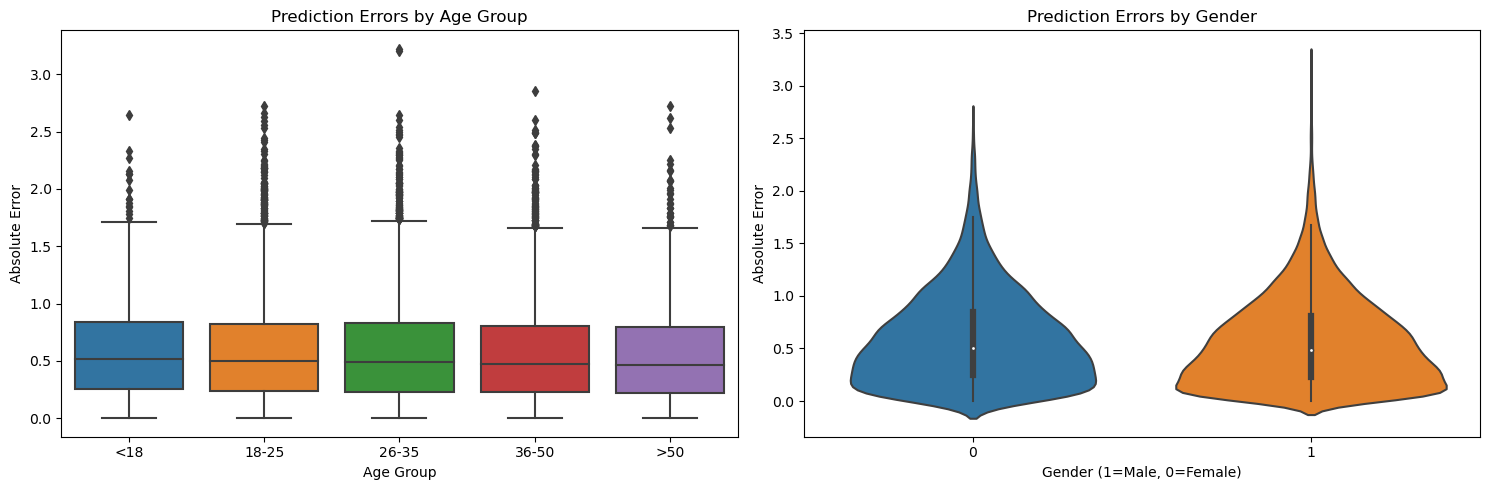

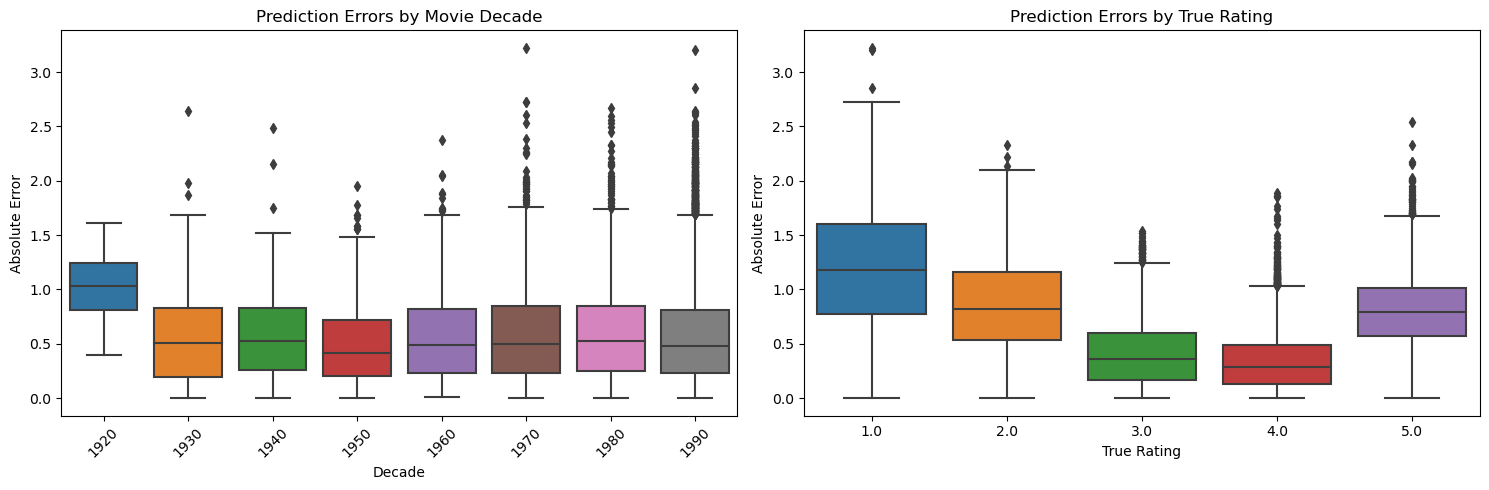

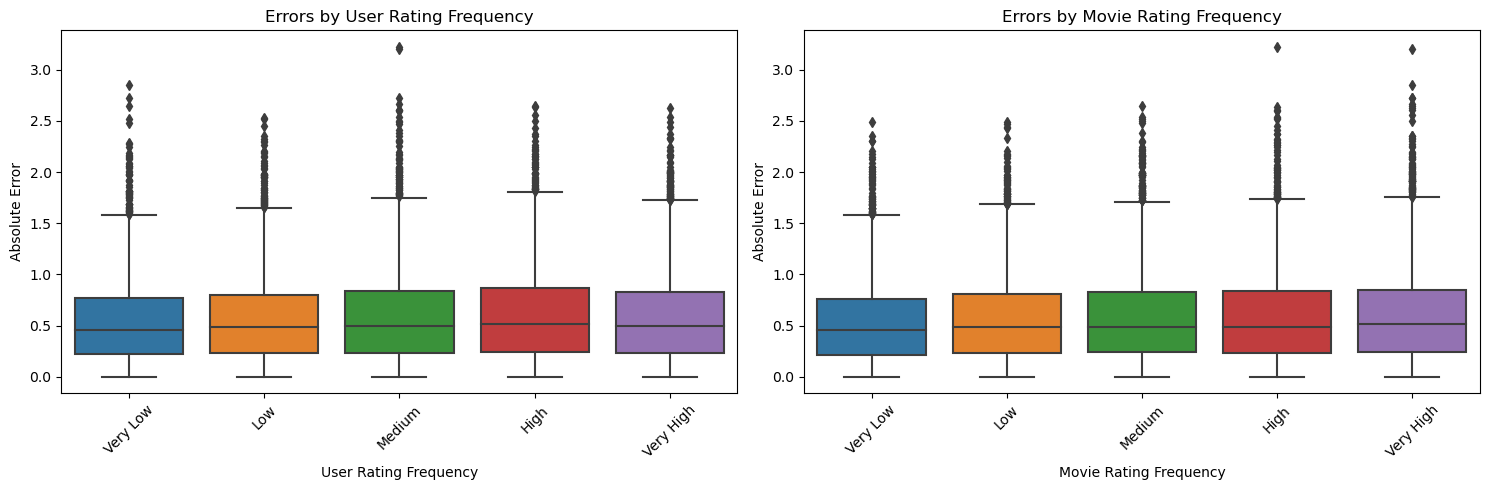

In [282]:
import pandas as pd
import numpy as np
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df[['user_id', 'movie_id', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
                            
test_predictions = []
test_true_ratings = []
test_users = []
test_movies = []

for uid, iid, true_r in testset:
    pred = best_model.predict(uid, iid).est
    test_predictions.append(pred)
    test_true_ratings.append(true_r)
    test_users.append(uid)
    test_movies.append(iid)

# Create DataFrame with test results
test_df = pd.DataFrame({
    'user_id': test_users,
    'movie_id': test_movies,
    'rating': test_true_ratings
})

# Generate error analysis report
report = generate_error_report(
    true_ratings=test_df,
    predicted_ratings=np.array(test_predictions),
    user_info=user_info_df,
    movie_info=movie_info_df
)

In [335]:
movie_info_df['release_year_decade'] = (movie_info_df['release_year']//10) * 10
pd.merge(ratings_df_orig.groupby('movie_id').count()['rating'], movie_info_df, on = 'movie_id').groupby('release_year_decade').sum()[['rating']]

/var/folders/rg/0dmq4k555055rrz2w28q4v2m0000gn/T/ipykernel_26468/3167698195.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd.merge(ratings_df_orig.groupby('movie_id').count()['rating'], movie_info_df, on = 'movie_id').groupby('release_year_decade').sum()[['rating']]


,rating
release_year_decade,
1920,48
1930,1346
1940,2015
1950,3140
1960,3483
1970,5642
1980,10870
1990,63448


In [344]:
avg_rating_by_decade = pd.merge(ratings_df_orig.groupby('movie_id').agg(['sum', 'count'])['rating'], movie_info_df, on = 'movie_id').groupby('release_year_decade').sum()[['sum','count']]
avg_rating_by_decade['avg_rating'] = avg_rating_by_decade['sum']/avg_rating_by_decade['count']
avg_rating_by_decade

/var/folders/rg/0dmq4k555055rrz2w28q4v2m0000gn/T/ipykernel_26468/1701636599.py:1: FutureWarning: ['frequency_group'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  avg_rating_by_decade = pd.merge(ratings_df_orig.groupby('movie_id').agg(['sum', 'count'])['rating'], movie_info_df, on = 'movie_id').groupby('release_year_decade').sum()[['sum','count']]
/var/folders/rg/0dmq4k555055rrz2w28q4v2m0000gn/T/ipykernel_26468/1701636599.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_rating_by_decade = pd.merge(ratings_df_orig.groupby('movie_id').agg(['sum', 'count'])['rating'], movie_info_df, on = 'movie_id').groupby('release_year_decade').sum()[['sum','count']]


,sum,count,avg_rating
release_year_decade,,,
1920,173,48,3.604167
1930,5259,1346,3.907132
1940,8083,2015,4.011414
1950,12388,3140,3.945223
1960,13510,3483,3.878840
1970,21820,5642,3.867423
1980,40772,10870,3.750874
1990,215620,63448,3.398373


In [296]:
rating_cnt_ratio = ratings_df_orig.groupby('rating').count()[['movie_id']]
rating_cnt_ratio['rating_cnt_ratio'] = rating_cnt_ratio['movie_id']/rating_cnt_ratio['movie_id'].sum()
rating_cnt_ratio

,movie_id,rating_cnt_ratio
rating,,
1,5499,0.061105
2,10248,0.113877
3,24412,0.271269
4,30771,0.341930
5,19062,0.211819


In [346]:
# Training the model by decade


def split_data_by_year(ratings_df, movie_info, year_threshold=1990):
    """Split the data into pre and post specified year"""
    merged_df = ratings_df.merge(movie_info[['movie_id', 'release_year']], on='movie_id')
    
    pre_1990 = merged_df[merged_df['release_year'] < year_threshold]
    post_1990 = merged_df[merged_df['release_year'] >= year_threshold]
    
    return pre_1990[['user_id', 'movie_id', 'rating']], post_1990[['user_id', 'movie_id', 'rating']]

def train_and_evaluate(ratings_df):
    """Train and evaluate model"""
    # Create Surprise reader and data
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(ratings_df[['user_id', 'movie_id', 'rating']], reader)
    
    # Create train-test split
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
    
    # Train model with best parameters
    model = SVDpp(**best_params)
    
    model.fit(trainset)
    predictions = model.test(testset)
    
    # Calculate RMSE
    rmse = np.sqrt(np.mean([float((pred.r_ui - pred.est) ** 2) for pred in predictions]))
    
    # Get rating distributions
    true_ratings = [pred.r_ui for pred in predictions]
    pred_ratings = [round(pred.est) for pred in predictions]
    
    distribution_df = pd.DataFrame({
        'true_distribution': pd.Series(true_ratings).value_counts().sort_index(),
        'predicted_distribution': pd.Series(pred_ratings).value_counts().sort_index()
    })
    
    return rmse, distribution_df

# Load data

# Split data by era
pre_1990_data, post_1990_data = split_data_by_year(ratings_df_orig, movie_info_df)

print(f"Pre-1990 dataset size: {len(pre_1990_data)}")
print(f"Post-1990 dataset size: {len(post_1990_data)}")

# Train and evaluate pre-1990 model
print("\nPre-1990 Model:")
pre_1990_rmse, pre_1990_dist = train_and_evaluate(pre_1990_data)
print(f"RMSE: {pre_1990_rmse:.4f}")
print("\nRating Distribution:")
print(pre_1990_dist)

# Train and evaluate post-1990 model
print("\nPost-1990 Model:")
post_1990_rmse, post_1990_dist = train_and_evaluate(post_1990_data)
print(f"RMSE: {post_1990_rmse:.4f}")
print("\nRating Distribution:")
print(post_1990_dist)

Pre-1990 dataset size: 26544
Post-1990 dataset size: 63448

Pre-1990 Model:
RMSE: 0.8681

Rating Distribution:
     true_distribution  predicted_distribution
1.0                162                     NaN
2.0                355                    64.0
3.0               1220                  1102.0
4.0               2027                  3737.0
5.0               1545                   406.0

Post-1990 Model:
RMSE: 0.9387

Rating Distribution:
     true_distribution  predicted_distribution
1.0                948                      57
2.0               1659                     869
3.0               3663                    5952
4.0               4179                    5566
5.0               2241                     246


In [348]:
train_and_evaluate(ratings_df_orig)

(0.9168368884858974,
      true_distribution  predicted_distribution
 1.0               1157                      45
 2.0               2057                     889
 3.0               4913                    6993
 4.0               6157                    9510
 5.0               3715                     562)

In [352]:
movie_cnt_by_year = movie_info_df.groupby('release_year').count()['movie_id']
movie_cnt_by_year

release_year
1922      1
1926      1
1930      1
1931      1
1932      1
       ... 
1994    214
1995    219
1996    355
1997    286
1998     65
Name: movie_id, Length: 71, dtype: int64

In [358]:
# mean moive rating for each year
avg_rating_by_year = pd.merge(ratings_df_orig.groupby('movie_id').agg(['sum', 'count'])['rating'], movie_info_df, on = 'movie_id').groupby('release_year').sum()[['sum','count']]
avg_rating_by_year['avg_rating'] = avg_rating_by_year['sum']/avg_rating_by_year['count']

/var/folders/rg/0dmq4k555055rrz2w28q4v2m0000gn/T/ipykernel_26468/3197537672.py:2: FutureWarning: ['frequency_group'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  avg_rating_by_year = pd.merge(ratings_df_orig.groupby('movie_id').agg(['sum', 'count'])['rating'], movie_info_df, on = 'movie_id').groupby('release_year').sum()[['sum','count']]
/var/folders/rg/0dmq4k555055rrz2w28q4v2m0000gn/T/ipykernel_26468/3197537672.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_rating_by_year = pd.merge(ratings_df_orig.groupby('movie_id').agg(['sum', 'count'])['rating'], movie_info_df, on = 'movie_id').groupby('release_year').sum()[['sum','count']]


In [359]:
avg_rating_df = pd.merge(avg_rating_by_year, movie_cnt_by_year, on= 'release_year')
avg_rating_df.rename(columns = {'sum':'rating_sum', 'count':'rating_count', 'movie_id':'released_movie_count'}, inplace = True)
avg_rating_df['rating_per_movie'] = round(avg_rating_df['rating_count']/avg_rating_df['released_movie_count'],2)
avg_rating_df

,rating_sum,rating_count,avg_rating,released_movie_count,rating_per_movie
release_year,,,,,
1922,169,47,3.595745,1,47.00
1926,4,1,4.000000,1,1.00
1930,68,18,3.777778,1,18.00
1931,154,39,3.948718,1,39.00
1932,46,12,3.833333,1,12.00
...,...,...,...,...,...
1994,27548,8039,3.426794,214,37.57
1995,32001,9502,3.367817,219,43.39
1996,58831,17698,3.324161,355,49.85


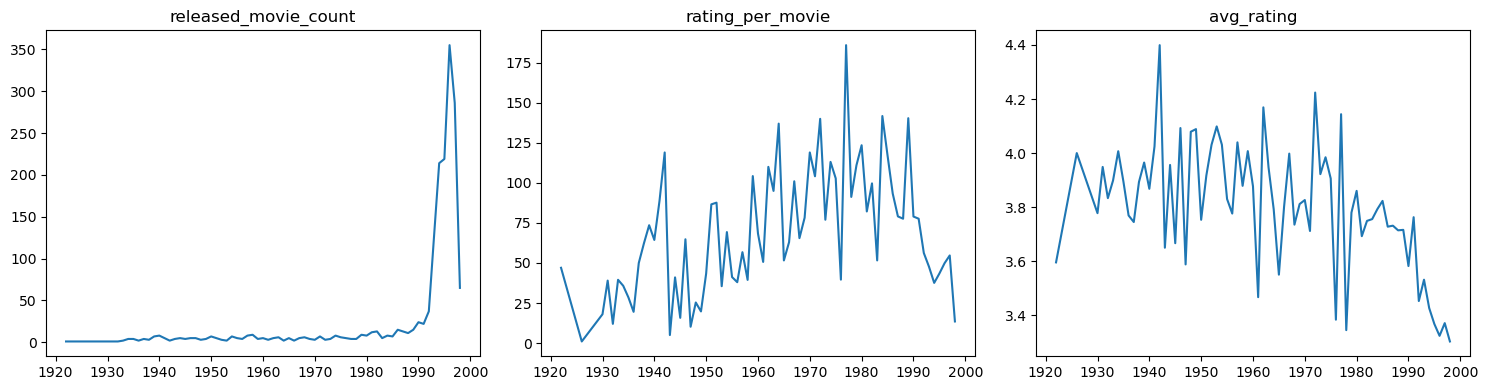

In [371]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(avg_rating_df.index, avg_rating_df['released_movie_count'])
axs[0].set_title('released_movie_count')

axs[1].plot(avg_rating_df.index, avg_rating_df['rating_per_movie'])
axs[1].set_title('rating_per_movie')

axs[2].plot(avg_rating_df.index, avg_rating_df['avg_rating'])
axs[2].set_title('avg_rating')


plt.tight_layout()
plt.show()

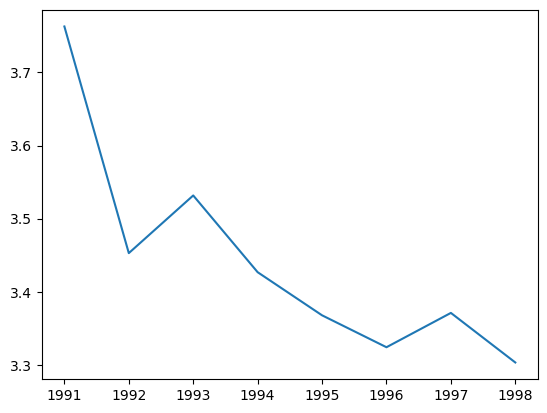

In [429]:
plt.plot(avg_rating_df[avg_rating_df.index >1990].index, avg_rating_df[avg_rating_df.index >1990]['avg_rating'])

In [372]:
#calibration for movies after 1990

from sklearn.isotonic import IsotonicRegression

def train_and_evaluate_with_calibration(ratings_df, is_post_1990=False):
    """Train and evaluate model with optional calibration for post-1990 movies"""
    # Create Surprise reader and data
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(ratings_df[['user_id', 'movie_id', 'rating']], reader)
    
    # Create train-test split
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
    
    # Train model with best parameters
    model = SVDpp(**best_params)
    model.fit(trainset)
    
    # Get raw predictions
    predictions = model.test(testset)
    
    # Extract true ratings and predicted ratings
    true_ratings = np.array([pred.r_ui for pred in predictions])
    raw_predictions = np.array([pred.est for pred in predictions])
    
    if is_post_1990:
        # Apply calibration only for post-1990 movies
        calibrator = IsotonicRegression(out_of_bounds='clip', y_min=1, y_max=5)
        calibrator.fit(raw_predictions, true_ratings)
        final_predictions = calibrator.predict(raw_predictions)
    else:
        final_predictions = raw_predictions
    
    # Calculate RMSE with calibrated predictions
    rmse = np.sqrt(np.mean((true_ratings - final_predictions) ** 2))
    
    # Get rating distributions
    pred_ratings = np.round(final_predictions)
    
    distribution_df = pd.DataFrame({
        'true_distribution': pd.Series(true_ratings).value_counts().sort_index(),
        'predicted_distribution': pd.Series(pred_ratings).value_counts().sort_index()
    })
    
    return rmse, distribution_df

# Your existing code for splitting data
pre_1990_data, post_1990_data = split_data_by_year(ratings_df_orig, movie_info_df)
print(f"Pre-1990 dataset size: {len(pre_1990_data)}")
print(f"Post-1990 dataset size: {len(post_1990_data)}")

# Train and evaluate pre-1990 model (without calibration)
print("\nPre-1990 Model:")
pre_1990_rmse, pre_1990_dist = train_and_evaluate_with_calibration(pre_1990_data, is_post_1990=False)
print(f"RMSE: {pre_1990_rmse:.4f}")
print("\nRating Distribution:")
print(pre_1990_dist)

# Train and evaluate post-1990 model (with calibration)
print("\nPost-1990 Model (with calibration):")
post_1990_rmse, post_1990_dist = train_and_evaluate_with_calibration(post_1990_data, is_post_1990=True)
print(f"RMSE: {post_1990_rmse:.4f}")
print("\nRating Distribution:")
print(post_1990_dist)

# Optional: Add function to visualize calibration results
def plot_calibration_results(true_ratings, predicted_ratings, title):
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.hist(true_ratings, alpha=0.5, label='True Ratings', bins=5)
    plt.hist(predicted_ratings, alpha=0.5, label='Predicted Ratings', bins=5)
    plt.title(title)
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.show()

Pre-1990 dataset size: 26544
Post-1990 dataset size: 63448

Pre-1990 Model:
RMSE: 0.8633

Rating Distribution:
     true_distribution  predicted_distribution
1.0                162                     NaN
2.0                355                    57.0
3.0               1220                  1104.0
4.0               2027                  3748.0
5.0               1545                   400.0

Post-1990 Model (with calibration):
RMSE: 0.9305

Rating Distribution:
     true_distribution  predicted_distribution
1.0                948                     118
2.0               1659                    1258
3.0               3663                    4816
4.0               4179                    6346
5.0               2241                     152


In [415]:
def add_time_features(ratings_df, movie_info_df):
    """Add time-based features with more conservative weighting"""
    merged_df = ratings_df.merge(movie_info_df[['movie_id', 'release_year']], on='movie_id')
    
    current_year = 2024
    merged_df['years_since_release'] = current_year - merged_df['release_year']
    merged_df['is_post_1990'] = (merged_df['release_year'] >= 1990).astype(int)
    
    # More conservative weighting
    time_weight = np.where(
        merged_df['is_post_1990'] == 1,
        1.0 - (merged_df['years_since_release'] / 150),  # Gentler decay for new movies
        1.0 + (merged_df['years_since_release'] / 200)   # Much gentler boost for old movies
    )
    
    # Tighter bounds on weights
    time_weight = np.clip(time_weight, 0.7, 1.25)  # Reduced maximum boost
    
    merged_df['adjusted_rating'] = merged_df['rating'] * time_weight
    merged_df['adjusted_rating'] = np.clip(merged_df['adjusted_rating'], 1, 5)
    
    return merged_df

def train_time_aware_model(ratings_df, movie_info_df):
    """Train model with time-aware ratings"""
    # Add time features
    enhanced_df = add_time_features(ratings_df, movie_info_df)
    
    # Create Surprise reader and data
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(enhanced_df[['user_id', 'movie_id', 'adjusted_rating']], reader)
    
    # Split data
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
    
    # Train model with best parameters
    model = SVDpp(**best_params)
    model.fit(trainset)
    
    # Make predictions
    predictions = model.test(testset)
    
    # Calculate metrics
    rmse = np.sqrt(np.mean([float((pred.r_ui - pred.est) ** 2) for pred in predictions]))
    
    # Get original test data for comparison
    test_df = enhanced_df[enhanced_df['user_id'].isin([pred.uid for pred in predictions])]
    
    # Get distributions
    true_ratings = [pred.r_ui for pred in predictions]
    pred_ratings = [round(pred.est) for pred in predictions]
    
    distribution_df = pd.DataFrame({
        'true_distribution': pd.Series(true_ratings).value_counts().sort_index(),
        'predicted_distribution': pd.Series(pred_ratings).value_counts().sort_index()
    })
    
    return rmse, distribution_df, model, enhanced_df

def analyze_by_era(enhanced_df, model):
    """Analyze model performance by era"""
    for era in ['Pre-1990', 'Post-1990']:
        # Filter data by era
        era_mask = enhanced_df['release_year'] < 1990 if era == 'Pre-1990' else enhanced_df['release_year'] >= 1990
        era_data = enhanced_df[era_mask]
        
        # Create test data
        reader = Reader(rating_scale=(1, 5))
        data = Dataset.load_from_df(era_data[['user_id', 'movie_id', 'adjusted_rating']], reader)
        _, testset = train_test_split(data, test_size=0.2, random_state=42)
        
        # Get predictions
        predictions = model.test(testset)
        
        # Calculate RMSE
        rmse = np.sqrt(np.mean([float((pred.r_ui - pred.est) ** 2) for pred in predictions]))
        
        print(f"\n{era} Results:")
        print(f"RMSE: {rmse:.4f}")
        
        # Show rating distribution
        true_ratings = [pred.r_ui for pred in predictions]
        pred_ratings = [round(pred.est) for pred in predictions]
        
        dist_df = pd.DataFrame({
            'true_distribution': pd.Series(true_ratings).value_counts().sort_index(),
            'predicted_distribution': pd.Series(pred_ratings).value_counts().sort_index()
        })
        print("\nRating Distribution:")
        print(dist_df)

# Train and evaluate
print("Training time-aware model...")
rmse, dist_df, model, enhanced_df = train_time_aware_model(ratings_df_orig, movie_info_df)

print(f"\nOverall RMSE: {rmse:.4f}")
print("\nOverall Rating Distribution:")
print(dist_df)

# Analyze by era
analyze_by_era(enhanced_df, model)

Training time-aware model...

Overall RMSE: 0.7625

Overall Rating Distribution:
       true_distribution  predicted_distribution
1.000              923.0                    96.0
1.175               10.0                     NaN
1.180                8.0                     NaN
1.185                8.0                     NaN
1.190               12.0                     NaN
...                  ...                     ...
4.920               19.0                     NaN
4.940               52.0                     NaN
4.960               14.0                     NaN
4.980               49.0                     NaN
5.000             2591.0                  2031.0

[97 rows x 2 columns]

Pre-1990 Results:
RMSE: 0.6982

Rating Distribution:
       true_distribution  predicted_distribution
1.000                NaN                     1.0
1.175               13.0                     NaN
1.180               10.0                     NaN
1.185                7.0                     NaN
1.190    

In [445]:
ratings_df

,user_id,movie_id,rating,rating_frequency,frequency_group
0,772,36,3,148,medium
1,471,228,5,236,high
2,641,401,4,288,very_high
3,312,98,4,236,high
4,58,504,5,350,very_high
...,...,...,...,...,...
89987,415,813,4,441,very_high
89988,842,120,3,188,medium
89989,574,505,2,23,very_low
89990,757,472,5,309,very_high


In [416]:
from surprise.model_selection import GridSearchCV

def grid_search_time_aware(ratings_df, movie_info_df):
    # First add time features
    enhanced_df = add_time_features(ratings_df, movie_info_df)
    
    # Create Surprise reader and data
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(enhanced_df[['user_id', 'movie_id', 'adjusted_rating']], reader)
    
    # Define parameter grid
    param_grid = {
        'n_factors': [50, 100, 150],
        'n_epochs': [20, 30],
        'lr_all': [0.005, 0.01],
        'reg_all': [0.02, 0.04, 0.06]
    }
    
    # Do grid search
    gs = GridSearchCV(SVDpp, param_grid, measures=['rmse'], 
                     cv=5, n_jobs=-1, joblib_verbose=2)
    
    gs.fit(data)
    
    # Print results
    print("\nBest parameters:")
    print(gs.best_params['rmse'])
    print(f"\nBest RMSE: {gs.best_score['rmse']:.4f}")
    
    return gs.best_params['rmse']

# Run grid search
best_time_aware_params_adjusted = grid_search_time_aware(ratings_df, movie_info_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  5.9min



Best parameters:
{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.06}

Best RMSE: 0.7576


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  8.9min finished


In [417]:
print(best_time_aware_params)
print(best_time_aware_params_adjusted)

{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.06}
{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.06}


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

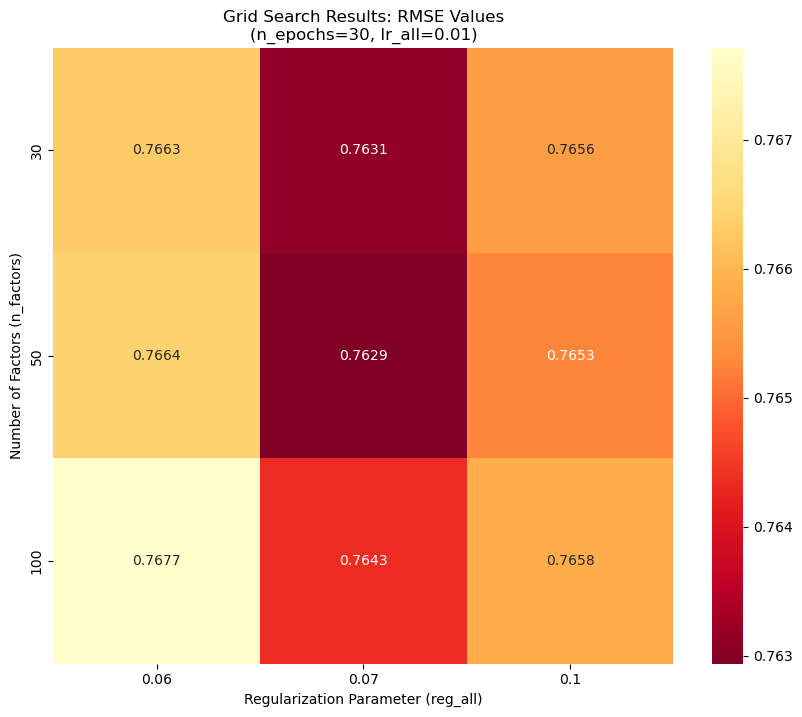

In [443]:
"""
Topic : heatmap on Grid Search
"""
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def create_grid_search_heatmap(ratings_df, movie_info_df):
    # Storage for results
    results = np.zeros((3, 3))  # 3x3 grid for n_factors and reg_all
    
    # Fixed parameters (best values)
    n_epochs = 30
    lr_all = 0.01
    
    # Parameters to vary
    n_factors_values = [30, 50, 100]
    reg_all_values = [0.06, 0.07, 0.1]
    
    # Get enhanced data
    enhanced_df = add_time_features(ratings_df, movie_info_df)
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(enhanced_df[['user_id', 'movie_id', 'adjusted_rating']], reader)
    
    # Create full training set
    trainset = data.build_full_trainset()
    
    # Grid search
    for i, n_factors in enumerate(n_factors_values):
        for j, reg_all in enumerate(reg_all_values):
            # Train model
            model = SVDpp(n_factors=n_factors, n_epochs=n_epochs, 
                         lr_all=lr_all, reg_all=reg_all)
            model.fit(trainset)
            
            # Get RMSE through cross-validation
            cv_results = cross_validate(model, data, measures=['rmse'], 
                                     cv=3, n_jobs=-1)
            results[i, j] = cv_results['test_rmse'].mean()
    
    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(results, annot=True, fmt='.4f', 
                xticklabels=reg_all_values,
                yticklabels=n_factors_values,
                cmap='YlOrRd_r')  # Reverse colormap so darker = better
    
    plt.xlabel('Regularization Parameter (reg_all)')
    plt.ylabel('Number of Factors (n_factors)')
    plt.title('Grid Search Results: RMSE Values\n(n_epochs=30, lr_all=0.01)')
    
    # Add colorbar label
    plt.colorbar(label='RMSE')
    
    plt.tight_layout()
    return plt

# Create and show heatmap
heatmap = create_grid_search_heatmap(ratings_df, movie_info_df)
plt.show()

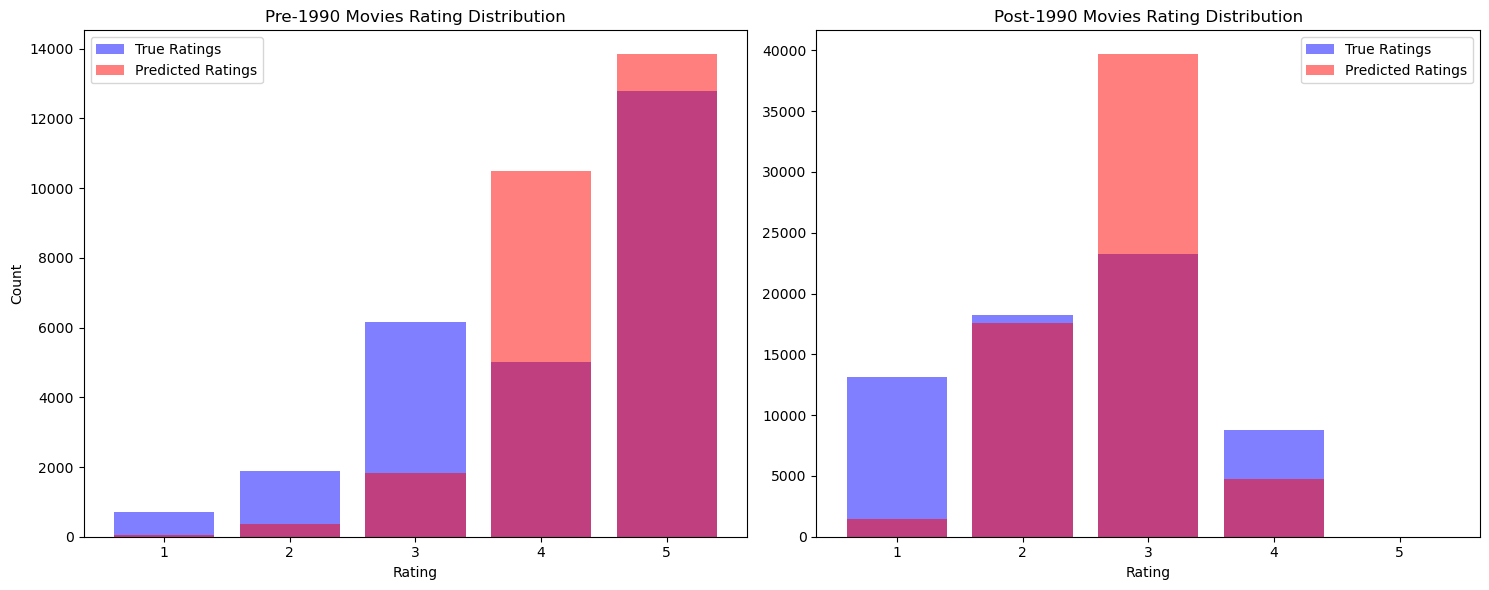


Pre-1990 Summary:
True ratings distribution:
1      716
2     1876
3     6152
4     5014
5    12786
dtype: int64

Predicted ratings distribution:
1       48
2      351
3     1822
4    10487
5    13836
dtype: int64

Post-1990 Summary:
True ratings distribution:
1    13155
2    18260
3    23278
4     8755
dtype: int64

Predicted ratings distribution:
1     1490
2    17568
3    39667
4     4722
5        1
dtype: int64


In [447]:
def analyze_predictions_by_era(ratings_df, movie_info_df, best_params):
    # Add time features
    enhanced_df = add_time_features(ratings_df, movie_info_df)
    
    # Split data by era
    pre_1990_df = enhanced_df[enhanced_df['release_year'] < 1990]
    post_1990_df = enhanced_df[enhanced_df['release_year'] >= 1990]
    
    # Create reader and dataset
    reader = Reader(rating_scale=(1, 5))
    
    # Function to get predictions for a dataset
    def get_predictions(df):
        data = Dataset.load_from_df(df[['user_id', 'movie_id', 'adjusted_rating']], reader)
        trainset = data.build_full_trainset()
        
        # Train model
        model = SVDpp(**best_params)
        model.fit(trainset)
        
        # Get predictions
        testset = trainset.build_testset()
        predictions = model.test(testset)
        
        true_ratings = [int(pred.r_ui) for pred in predictions]
        pred_ratings = [int(round(pred.est)) for pred in predictions]  # Round and convert to int
        
        return true_ratings, pred_ratings
    
    # Get predictions for both eras
    pre_1990_true, pre_1990_pred = get_predictions(pre_1990_df)
    post_1990_true, post_1990_pred = get_predictions(post_1990_df)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Pre-1990 plot
    # Use value_counts to get distribution of integer ratings
    pre_1990_true_counts = pd.Series(pre_1990_true).value_counts().sort_index()
    pre_1990_pred_counts = pd.Series(pre_1990_pred).value_counts().sort_index()
    
    ax1.bar(pre_1990_true_counts.index, pre_1990_true_counts.values, alpha=0.5, 
           color='blue', label='True Ratings')
    ax1.bar(pre_1990_pred_counts.index, pre_1990_pred_counts.values, alpha=0.5, 
           color='red', label='Predicted Ratings')
    ax1.set_title('Pre-1990 Movies Rating Distribution')
    ax1.set_xlabel('Rating')
    ax1.set_ylabel('Count')
    ax1.legend()
    ax1.set_xticks([1, 2, 3, 4, 5])
    
    # Post-1990 plot
    post_1990_true_counts = pd.Series(post_1990_true).value_counts().sort_index()
    post_1990_pred_counts = pd.Series(post_1990_pred).value_counts().sort_index()
    
    ax2.bar(post_1990_true_counts.index, post_1990_true_counts.values, alpha=0.5, 
           color='blue', label='True Ratings')
    ax2.bar(post_1990_pred_counts.index, post_1990_pred_counts.values, alpha=0.5, 
           color='red', label='Predicted Ratings')
    ax2.set_title('Post-1990 Movies Rating Distribution')
    ax2.set_xlabel('Rating')
    ax2.legend()
    ax2.set_xticks([1, 2, 3, 4, 5])
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nPre-1990 Summary:")
    print("True ratings distribution:")
    print(pre_1990_true_counts)
    print("\nPredicted ratings distribution:")
    print(pre_1990_pred_counts)
    
    print("\nPost-1990 Summary:")
    print("True ratings distribution:")
    print(post_1990_true_counts)
    print("\nPredicted ratings distribution:")
    print(post_1990_pred_counts)
    
    return pre_1990_true, pre_1990_pred, post_1990_true, post_1990_pred

# Run analysis
pre_1990_true, pre_1990_pred, post_1990_true, post_1990_pred = \
    analyze_predictions_by_era(ratings_df, movie_info_df, best_time_aware_params_adjusted)

In [451]:
def calculate_mae_by_era(ratings_df, movie_info_df, best_params):
    # Add time features
    enhanced_df = add_time_features(ratings_df, movie_info_df)
    
    # Split data by era
    pre_1990_df = enhanced_df[enhanced_df['release_year'] < 1990]
    post_1990_df = enhanced_df[enhanced_df['release_year'] >= 1990]
    
    # Create reader and dataset
    reader = Reader(rating_scale=(1, 5))
    
    # Function to get MAE for a dataset
    def get_mae(df):
        data = Dataset.load_from_df(df[['user_id', 'movie_id', 'adjusted_rating']], reader)
        trainset = data.build_full_trainset()
        
        # Train model
        model = SVDpp(**best_params)
        model.fit(trainset)
        
        # Get predictions
        testset = trainset.build_testset()
        predictions = model.test(testset)
        
        # Calculate MAE
        mae = np.mean([abs(pred.r_ui - pred.est) for pred in predictions])
        
        return mae
    
    # Calculate MAE for both eras and overall
    pre_1990_mae = get_mae(pre_1990_df)
    post_1990_mae = get_mae(post_1990_df)
    overall_mae = get_mae(enhanced_df)
    
    return overall_mae, pre_1990_mae, post_1990_mae

# Calculate MAE
overall_mae, pre_1990_mae, post_1990_mae = calculate_mae_by_era(ratings_df, movie_info_df, best_time_aware_params_adjusted)

print(f"Overall MAE: {overall_mae:.4f}")
print(f"Pre-1990 MAE: {pre_1990_mae:.4f}")
print(f"Post-1990 MAE: {post_1990_mae:.4f}")

Overall MAE: 0.4539
Pre-1990 MAE: 0.4087
Post-1990 MAE: 0.4476



Overall MAE: 0.4534339304482511

MAE by decade:
1920s: 0.5193 (n=48)
1930s: 0.4347 (n=1346)
1940s: 0.3956 (n=2015)
1950s: 0.3871 (n=3140)
1960s: 0.4469 (n=3483)
1970s: 0.4663 (n=5642)
1980s: 0.4977 (n=10870)
1990s: 0.4505 (n=63448)


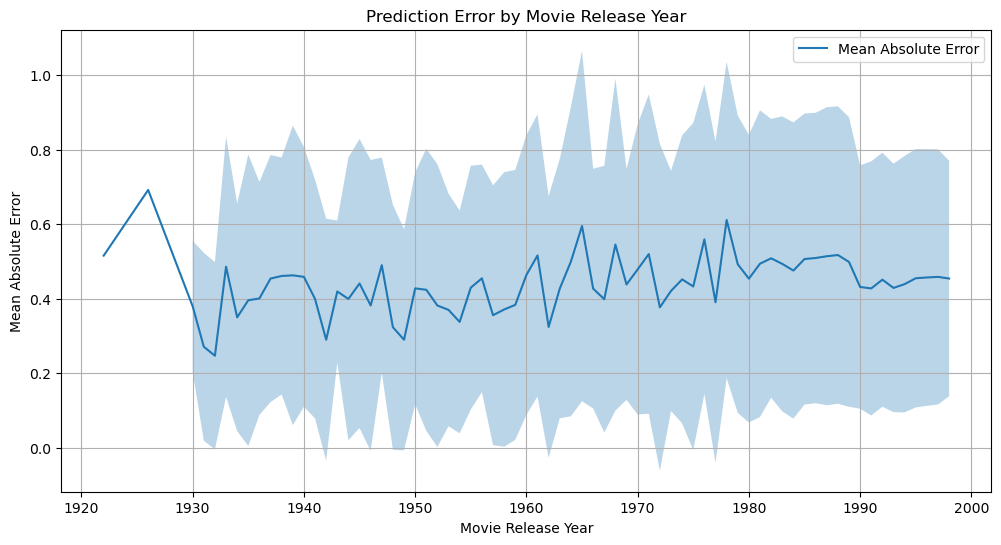

In [452]:
def analyze_errors_by_release_year(ratings_df, movie_info_df, best_params):
    # Add time features
    enhanced_df = add_time_features(ratings_df, movie_info_df)
    
    # Create reader and dataset
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(enhanced_df[['user_id', 'movie_id', 'adjusted_rating']], reader)
    
    # Build full trainset and train model
    trainset = data.build_full_trainset()
    model = SVDpp(**best_params)
    model.fit(trainset)
    
    # Get predictions
    testset = trainset.build_testset()
    predictions = model.test(testset)
    
    # Create DataFrame with predictions and errors
    prediction_df = pd.DataFrame({
        'user_id': [pred.uid for pred in predictions],
        'movie_id': [pred.iid for pred in predictions],
        'true_rating': [pred.r_ui for pred in predictions],
        'predicted_rating': [pred.est for pred in predictions]
    })
    
    # Add release year information
    prediction_df = prediction_df.merge(
        movie_info_df[['movie_id', 'release_year']], 
        on='movie_id'
    )
    
    # Calculate errors
    prediction_df['error'] = abs(prediction_df['true_rating'] - prediction_df['predicted_rating'])
    
    # Calculate mean error and std by release year
    yearly_errors = prediction_df.groupby('release_year').agg({
        'error': ['mean', 'std', 'count']
    }).reset_index()
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    
    plt.plot(yearly_errors['release_year'], 
            yearly_errors['error']['mean'], 
            label='Mean Absolute Error')
    
    # Add confidence interval
    plt.fill_between(yearly_errors['release_year'],
                    yearly_errors['error']['mean'] - yearly_errors['error']['std'],
                    yearly_errors['error']['mean'] + yearly_errors['error']['std'],
                    alpha=0.3)
    
    plt.xlabel('Movie Release Year')
    plt.ylabel('Mean Absolute Error')
    plt.title('Prediction Error by Movie Release Year')
    plt.grid(True)
    plt.legend()
    
    # Print summary statistics
    print("\nOverall MAE:", prediction_df['error'].mean())
    print("\nMAE by decade:")
    for decade in range(1920, 2000, 10):
        decade_data = prediction_df[
            (prediction_df['release_year'] >= decade) & 
            (prediction_df['release_year'] < decade + 10)
        ]
        if len(decade_data) > 0:
            print(f"{decade}s: {decade_data['error'].mean():.4f} (n={len(decade_data)})")
    
    plt.show()
    
    return yearly_errors

# Run the analysis
yearly_error_results = analyze_errors_by_release_year(ratings_df, movie_info_df, best_time_aware_params_adjusted)

In [400]:
def refined_grid_search_time_aware(ratings_df, movie_info_df):
    # Add time features
    enhanced_df = add_time_features(ratings_df, movie_info_df)
    
    # Create Surprise reader and data
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(enhanced_df[['user_id', 'movie_id', 'adjusted_rating']], reader)
    
    # Define refined parameter grid based on previous best results
    param_grid = {
        'n_factors': [40, 50, 60],        # Around 50
        'n_epochs': [25, 30, 35],         # Around 30
        'lr_all': [0.008, 0.01, 0.012],   # Around 0.01
        'reg_all': [0.05, 0.06, 0.07]     # Around 0.06
    }
    
    # Do grid search
    gs = GridSearchCV(SVDpp, param_grid, measures=['rmse'], 
                     cv=3, n_jobs=-1, joblib_verbose=2)
    
    gs.fit(data)
    
    # Print results
    print("\nBest parameters:")
    print(gs.best_params['rmse'])
    print(f"\nBest RMSE: {gs.best_score['rmse']:.4f}")
    
    return gs.best_params['rmse']

# Run refined grid search
best_refined_params = refined_grid_search_time_aware(ratings_df, movie_info_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  3.1min



Best parameters:
{'n_factors': 40, 'n_epochs': 35, 'lr_all': 0.01, 'reg_all': 0.07}

Best RMSE: 0.6564


[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  5.6min finished


In [418]:
def train_final_model(ratings_df, movie_info_df, best_params):
    # Add time features
    enhanced_df = add_time_features(ratings_df, movie_info_df)
    
    # Create data for full training
    reader = Reader(rating_scale=(1, 5))
    full_data = Dataset.load_from_df(enhanced_df[['user_id', 'movie_id', 'adjusted_rating']], reader)
    trainset = full_data.build_full_trainset()
    
    # Train final model
    final_model = SVDpp(**best_params)
    final_model.fit(trainset)
    
    return final_model, enhanced_df

# Train final model
final_model, enhanced_df = train_final_model(ratings_df, movie_info_df, best_time_aware_params_adjusted)

In [419]:
def predict_full_dataset(model, ratings_df, movie_info_df, output_file='predictions.txt'):
    # Add time features to get enhanced dataframe
    enhanced_df = add_time_features(ratings_df, movie_info_df)
    
    # Get predictions for all user-movie pairs
    predictions = []
    for _, row in enhanced_df.iterrows():
        pred = model.predict(row['user_id'], row['movie_id']).est
        # Round to nearest integer and ensure it's within 1-5 range
        pred_int = int(round(np.clip(pred, 1, 5)))
        predictions.append(pred_int)
    
    # Write predictions to file
    with open(output_file, 'w') as f:
        for pred in predictions:
            f.write(f"{pred}\n")
    
    print(f"Predictions written to {output_file}")
    print(f"Total predictions: {len(predictions)}")
    
    # Print distribution of predictions
    pred_dist = pd.Series(predictions).value_counts().sort_index()
    print("\nPrediction distribution:")
    print(pred_dist)

# Use the function with your trained model
predict_full_dataset(final_model, test_set, movie_info_df)

Predictions written to predictions.txt
Total predictions: 10000

Prediction distribution:
1     138
2    1789
3    4776
4    2042
5    1255
dtype: int64


In [421]:
counts

1      28
2     571
3    3803
4    5264
5     334
dtype: int64

In [413]:
def predict_full_dataset(model, ratings_df, movie_info_df, output_file='predictions.txt'):
    # Add time features to get enhanced dataframe
    enhanced_df = add_time_features(ratings_df, movie_info_df)
    
    # Get predictions for all user-movie pairs
    predictions = []
    for _, row in enhanced_df.iterrows():
        pred = model.predict(row['user_id'], row['movie_id']).est
        # Round to nearest integer and ensure it's within 1-5 range
        pred_int = int(round(np.clip(pred, 1, 5)))
        predictions.append(pred_int)
    
    # Write predictions to file
    with open(output_file, 'w') as f:
        for pred in predictions:
            f.write(f"{pred}\n")
    
    print(f"Predictions written to {output_file}")
    print(f"Total predictions: {len(predictions)}")
    
    # Print distribution of predictions
    pred_dist = pd.Series(predictions).value_counts().sort_index()
    print("\nPrediction distribution:")
    print(pred_dist)

# Use the function with your trained model
predict_full_dataset(final_model, test_set, movie_info_df)

Predictions written to predictions.txt
Total predictions: 10000

Prediction distribution:
1     213
2    3342
3    3511
4     915
5    2019
dtype: int64


In [432]:
def grid_search_by_era(ratings_df, movie_info_df):
    # Split data by era
    pre_1992_data, post_1992_data = split_data_by_year(ratings_df, movie_info_df, year_threshold=1992)
    
    # Parameter grid
    param_grid = {
        'n_factors': [40, 60, 100],
        'n_epochs': [25, 35],
        'lr_all': [0.008, 0.01, 0.012],
        'reg_all': [0.06, 0.07, 0.1]
    }
    
    # Grid search for pre-1992
    print("Running grid search for pre-1992 model...")
    reader = Reader(rating_scale=(1, 5))
    pre_data = Dataset.load_from_df(pre_1992_data[['user_id', 'movie_id', 'rating']], reader)
    
    gs_pre = GridSearchCV(SVDpp, param_grid, measures=['rmse'], 
                         cv=3, n_jobs=-1, joblib_verbose=2)
    gs_pre.fit(pre_data)
    
    print("\nPre-1992 Best parameters:")
    print(gs_pre.best_params['rmse'])
    print(f"Pre-1992 Best RMSE: {gs_pre.best_score['rmse']:.4f}")
    
    # Grid search for post-1992
    print("\nRunning grid search for post-1992 model...")
    post_data = Dataset.load_from_df(post_1992_data[['user_id', 'movie_id', 'rating']], reader)
    
    gs_post = GridSearchCV(SVDpp, param_grid, measures=['rmse'], 
                          cv=3, n_jobs=-1, joblib_verbose=2)
    gs_post.fit(post_data)
    
    print("\nPost-1992 Best parameters:")
    print(gs_post.best_params['rmse'])
    print(f"Post-1992 Best RMSE: {gs_post.best_score['rmse']:.4f}")
    
    return gs_pre.best_params['rmse'], gs_post.best_params['rmse']

# Run grid search for both eras
pre_1992_params, post_1992_params = grid_search_by_era(ratings_df, movie_info_df)

Running grid search for pre-1992 model...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   43.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.



Pre-1992 Best parameters:
{'n_factors': 100, 'n_epochs': 35, 'lr_all': 0.012, 'reg_all': 0.1}
Pre-1992 Best RMSE: 0.8689

Running grid search for post-1992 model...


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  1.8min



Post-1992 Best parameters:
{'n_factors': 60, 'n_epochs': 35, 'lr_all': 0.008, 'reg_all': 0.1}
Post-1992 Best RMSE: 0.9495


[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  2.2min finished


In [436]:
def train_era_models_and_predict(ratings_df, movie_info_df, test_df, pre_1992_params, post_1992_params, output_file='predictions.txt'):
    # Split training data by era
    pre_1992_data, post_1992_data = split_data_by_year(ratings_df, movie_info_df, year_threshold=1992)
    
    # Train pre-1992 model
    reader = Reader(rating_scale=(1, 5))
    pre_1992_data = Dataset.load_from_df(pre_1992_data[['user_id', 'movie_id', 'rating']], reader)
    pre_1992_trainset = pre_1992_data.build_full_trainset()
    
    pre_1992_model = SVDpp(**pre_1992_params)
    pre_1992_model.fit(pre_1992_trainset)
    
    # Train post-1992 model
    post_1992_data = Dataset.load_from_df(post_1992_data[['user_id', 'movie_id', 'rating']], reader)
    post_1992_trainset = post_1992_data.build_full_trainset()
    
    post_1992_model = SVDpp(**post_1992_params)
    post_1992_model.fit(post_1992_trainset)
    
    # Make predictions on test set
    predictions = []
    test_with_year = test_df.merge(movie_info_df[['movie_id', 'release_year']], on='movie_id')
    
    for _, row in test_with_year.iterrows():
        if row['release_year'] < 1992:
            model = pre_1992_model
        else:
            model = post_1992_model
            
        pred = model.predict(row['user_id'], row['movie_id']).est
        pred_int = int(round(np.clip(pred, 1, 5)))
        predictions.append(pred_int)
    
    # Write predictions to file
    with open(output_file, 'w') as f:
        for pred in predictions:
            f.write(f"{pred}\n")
    
    print(f"Total predictions written: {len(predictions)}")
    pred_dist = pd.Series(predictions).value_counts().sort_index()
    print("\nPrediction distribution:")
    print(pred_dist)

# Usage:
train_era_models_and_predict(
    ratings_df=ratings_df_orig,  # Your training data
    movie_info_df=movie_info_df,
    test_df=test_set,            # Your test set with user_id, movie_id
    pre_1992_params=pre_1992_params,
    post_1992_params=post_1992_params,
    output_file='predictions.txt'
)

Total predictions written: 10000

Prediction distribution:
1      49
2     601
3    3802
4    5120
5     428
dtype: int64


# Weigths for Distribution Adjustment

In [292]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_rating_weights(ratings_df):
    """
    Calculate inverse frequency weights for each rating value
    """
    # Count occurrences of each rating
    rating_counts = {
        1: 5499,
        2: 10248,
        3: 24412,
        4: 30771,
        5: 19062
    }
    
    total_ratings = sum(rating_counts.values())
    
    # Calculate inverse weights (less frequent ratings get higher weights)
    weights = {
        rating: total_ratings / (count * 5)  # multiply by 5 to normalize
        for rating, count in rating_counts.items()
    }
    
    return weights

def weighted_rmse(y_true, y_pred, weights_dict):
    """
    Calculate weighted RMSE giving more importance to rare ratings
    """
    weights = np.array([weights_dict[int(y)] for y in y_true])
    squared_errors = (y_true - y_pred) ** 2
    weighted_mse = np.average(squared_errors, weights=weights)
    return np.sqrt(weighted_mse)

def analyze_prediction_bias(y_true, y_pred):
    """
    Analyze prediction bias for each rating value
    """
    results = {}
    for rating in range(1, 6):
        mask = (y_true == rating)
        if np.any(mask):
            bias = np.mean(y_pred[mask] - y_true[mask])
            rmse = np.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))
            count = np.sum(mask)
            results[rating] = {
                'bias': bias,
                'rmse': rmse,
                'count': count
            }
    return results

def analyze_rating_distribution(y_true, y_pred):
    """
    Compare distribution of true ratings vs predicted ratings
    """
    true_dist = pd.Series(y_true).value_counts().sort_index()
    pred_dist = pd.Series(np.round(y_pred).clip(1, 5)).value_counts().sort_index()
    
    return pd.DataFrame({
        'true_distribution': true_dist,
        'predicted_distribution': pred_dist
    })

def compute_enhanced_metrics(y_true, y_pred):
    """
    Compute comprehensive set of metrics including weighted versions
    """
    # Calculate weights
    weights = calculate_rating_weights(None)  # Using hardcoded counts
    
    # Standard metrics
    standard_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    standard_mae = mean_absolute_error(y_true, y_pred)
    
    # Weighted metrics
    weighted_rmse_score = weighted_rmse(y_true, y_pred, weights)
    
    # Bias analysis
    bias_analysis = analyze_prediction_bias(y_true, y_pred)
    
    # Distribution analysis
    dist_analysis = analyze_rating_distribution(y_true, y_pred)
    
    return {
        'standard_metrics': {
            'rmse': standard_rmse,
            'mae': standard_mae
        },
        'weighted_metrics': {
            'weighted_rmse': weighted_rmse_score
        },
        'bias_analysis': bias_analysis,
        'distribution_analysis': dist_analysis
    }

# Usage example:
def evaluate_model_with_weights(model, testset):
    """
    Evaluate model with enhanced metrics
    """
    # Get predictions
    test_predictions = []
    test_true_ratings = []
    
    for uid, iid, true_r in testset:
        pred = model.predict(uid, iid).est
        test_predictions.append(pred)
        test_true_ratings.append(true_r)
    
    # Convert to numpy arrays
    y_true = np.array(test_true_ratings)
    y_pred = np.array(test_predictions)
    
    # Calculate enhanced metrics
    metrics = compute_enhanced_metrics(y_true, y_pred)
    
    # Print results
    print("\nStandard Metrics:")
    print(f"RMSE: {metrics['standard_metrics']['rmse']:.4f}")
    print(f"MAE: {metrics['standard_metrics']['mae']:.4f}")
    
    print("\nWeighted Metrics:")
    print(f"Weighted RMSE: {metrics['weighted_metrics']['weighted_rmse']:.4f}")
    
    print("\nBias Analysis by Rating:")
    for rating, stats in metrics['bias_analysis'].items():
        print(f"\nRating {rating}:")
        print(f"Bias: {stats['bias']:.4f}")
        print(f"RMSE: {stats['rmse']:.4f}")
        print(f"Count: {stats['count']}")
    
    print("\nRating Distribution Comparison:")
    print(metrics['distribution_analysis'])
    
    return metrics

In [293]:
metrics = evaluate_model_with_weights(best_model, testset)


Standard Metrics:
RMSE: 0.7166
MAE: 0.5709

Weighted Metrics:
Weighted RMSE: 0.8920

Bias Analysis by Rating:

Rating 1:
Bias: 1.2062
RMSE: 1.3397
Count: 1157

Rating 2:
Bias: 0.8386
RMSE: 0.9590
Count: 2057

Rating 3:
Bias: 0.3128
RMSE: 0.5097
Count: 4913

Rating 4:
Bias: -0.2444
RMSE: 0.4306
Count: 6157

Rating 5:
Bias: -0.8088
RMSE: 0.8769
Count: 3715

Rating Distribution Comparison:
     true_distribution  predicted_distribution
1.0               1157                     145
2.0               2057                    1237
3.0               4913                    6499
4.0               6157                    9370
5.0               3715                     748


In [323]:
import numpy as np
from surprise import AlgoBase
from surprise import PredictionImpossible

class SVDppWithCustomLoss(AlgoBase):
    def __init__(self, n_factors=150, n_epochs=30, lr_all=0.01, 
                 reg_all=0.01, init_mean=0, init_std_dev=0.1):
        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.lr_all = lr_all
        self.reg_all = reg_all
        self.init_mean = init_mean
        self.init_std_dev = init_std_dev
        
        AlgoBase.__init__(self)

    def extreme_weight(self, r):
        """Modified weights to reduce extreme predictions"""
        if r == 1:
            return 1.5  # reduced from 2.0
        elif r == 5:
            return 1.0  # reduced from 2.0
        elif r == 4:
            return 1.5  # new weight to encourage 4-star predictions
        elif r == 2:
            return 1.2
        return 1.0

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        
        # Initialize parameters
        self.bu = np.zeros(trainset.n_users, np.double)
        self.bi = np.zeros(trainset.n_items, np.double)
        self.pu = np.random.normal(self.init_mean, self.init_std_dev,
                                 (trainset.n_users, self.n_factors))
        self.qi = np.random.normal(self.init_mean, self.init_std_dev,
                                 (trainset.n_items, self.n_factors))
        
        for _ in range(self.n_epochs):
            for u, i, r in trainset.all_ratings():
                # Compute error
                dot = np.dot(self.pu[u], self.qi[i])
                pred = self.trainset.global_mean + self.bu[u] + self.bi[i] + dot
                err = r - pred
                
                # Apply weight based on rating value
                w = self.extreme_weight(r)
                err *= w
                
                # Update parameters
                self.bu[u] += self.lr_all * (err - self.reg_all * self.bu[u])
                self.bi[i] += self.lr_all * (err - self.reg_all * self.bi[i])
                self.pu[u] += self.lr_all * (err * self.qi[i] - self.reg_all * self.pu[u])
                self.qi[i] += self.lr_all * (err * self.pu[u] - self.reg_all * self.qi[i])
        
        return self

    def estimate(self, u, i):
        known_user = self.trainset.knows_user(u)
        known_item = self.trainset.knows_item(i)
        
        if not (known_user and known_item):
            raise PredictionImpossible('User or item not in training set.')
        
        est = self.trainset.global_mean + self.bu[u] + self.bi[i]
        est += np.dot(self.pu[u], self.qi[i])
        return est

In [298]:
def spread_predictions(predictions, target_std=1.2):
    """
    Adjust predictions to have wider spread while maintaining relative order
    """
    preds = np.array([pred.est for pred in predictions])
    current_std = np.std(preds)
    scaling_factor = target_std / current_std
    
    # Center, scale, and shift back
    mean_pred = np.mean(preds)
    adjusted_preds = (preds - mean_pred) * scaling_factor + mean_pred
    
    # Clip to valid range
    adjusted_preds = np.clip(adjusted_preds, 1, 5)
    
    # Update predictions
    for pred, adj_val in zip(predictions, adjusted_preds):
        pred.est = adj_val
    
    return predictions

In [299]:
def add_extreme_bias_correction(predictions, true_ratings):
    """
    Apply bias correction specifically for extreme ratings
    """
    # Calculate average bias for each rating
    bias_by_rating = {}
    for pred, true_r in zip(predictions, true_ratings):
        if true_r not in bias_by_rating:
            bias_by_rating[true_r] = []
        bias_by_rating[true_r].append(pred.est - true_r)
    
    avg_bias = {r: np.mean(b) for r, b in bias_by_rating.items()}
    
    # Apply correction factors
    for pred in predictions:
        if pred.est <= 2:
            pred.est -= avg_bias.get(1, 0) * 0.5
        elif pred.est >= 4:
            pred.est -= avg_bias.get(5, 0) * 0.5
    
    return predictions

In [300]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

def create_weighted_trainset(ratings_df):
    """
    Create weighted training set giving more importance to extreme ratings
    """
    weights = {
        1: 2.0,  # Double weight for 1-star ratings
        2: 1.5,  # 50% more weight for 2-star ratings
        3: 1.0,
        4: 1.0,
        5: 2.0   # Double weight for 5-star ratings
    }
    
    # Duplicate rows based on weights
    weighted_ratings = []
    for _, row in ratings_df.iterrows():
        weight = weights[row['rating']]
        n_copies = int(weight)
        for _ in range(n_copies):
            weighted_ratings.append(row)
    
    weighted_df = pd.DataFrame(weighted_ratings)
    
    # Create Surprise dataset
    reader = Reader(rating_scale=(1, 5))
    return Dataset.load_from_df(weighted_df[['user_id', 'movie_id', 'rating']], reader)

In [324]:
from collections import namedtuple
from surprise import Prediction

def spread_predictions(predictions, target_std=1.2):
    """
    Adjust predictions to have wider spread while maintaining relative order
    Returns new prediction objects instead of modifying existing ones
    """
    # Extract prediction values
    preds = np.array([pred.est for pred in predictions])
    
    # Calculate adjusted predictions
    current_std = np.std(preds)
    scaling_factor = target_std / current_std
    mean_pred = np.mean(preds)
    adjusted_preds = (preds - mean_pred) * scaling_factor + mean_pred
    adjusted_preds = np.clip(adjusted_preds, 1, 5)
    
    # Create new prediction objects
    new_predictions = []
    for old_pred, new_est in zip(predictions, adjusted_preds):
        new_pred = Prediction(uid=old_pred.uid,
                            iid=old_pred.iid,
                            r_ui=old_pred.r_ui,
                            est=new_est,
                            details=old_pred.details)
        new_predictions.append(new_pred)
    
    return new_predictions

def add_extreme_bias_correction(predictions, true_ratings):
    """
    Apply bias correction specifically for extreme ratings
    Returns new prediction objects
    """
    # Calculate average bias for each rating
    bias_by_rating = {}
    for pred, true_r in zip(predictions, true_ratings):
        if true_r not in bias_by_rating:
            bias_by_rating[true_r] = []
        bias_by_rating[true_r].append(pred.est - true_r)
    
    avg_bias = {r: np.mean(b) for r, b in bias_by_rating.items()}
    
    # Apply correction factors and create new predictions
    new_predictions = []
    for pred in predictions:
        new_est = pred.est
        if new_est <= 2:
            new_est -= avg_bias.get(1, 0) * 0.5
        elif new_est >= 4:
            new_est -= avg_bias.get(5, 0) * 0.5
        
        new_est = np.clip(new_est, 1, 5)
        
        new_pred = Prediction(uid=pred.uid,
                            iid=pred.iid,
                            r_ui=pred.r_ui,
                            est=new_est,
                            details=pred.details)
        new_predictions.append(new_pred)
    
    return new_predictions

# Usage:

model = SVDppWithCustomLoss(
        n_factors=150,  # from best_params
        n_epochs=30,    # from best_params
        lr_all=0.01,    # from best_params
        reg_all=0.1    # from best_params
    )
# 1. Get predictions
# 1. Create and train model with custom loss
model = SVDppWithCustomLoss()
model.fit(trainset)

# 2. Get predictions and apply all corrections
predictions = model.test(testset)


# 2. Apply post-processing
spread_preds = spread_predictions(predictions)

# 3. Apply bias correction
true_ratings = [r for _, _, r in testset]
final_preds = add_extreme_bias_correction(spread_preds, true_ratings)

# Analyze results
def analyze_distribution(predictions, true_ratings):
    pred_ratings = np.array([pred.est for pred in predictions])
    pred_rounded = np.round(pred_ratings)
    
    true_dist = pd.Series(true_ratings).value_counts().sort_index()
    pred_dist = pd.Series(pred_rounded).value_counts().sort_index()
    
    comparison = pd.DataFrame({
        'true_distribution': true_dist,
        'predicted_distribution': pred_dist
    })
    print("\nRating Distribution Comparison:")
    print(comparison)
    
    return comparison

# Compare original vs processed predictions
print("Original predictions distribution:")
analyze_distribution(predictions, true_ratings)
print("\nProcessed predictions distribution:")
analyze_distribution(final_preds, true_ratings)

Original predictions distribution:

Rating Distribution Comparison:
     true_distribution  predicted_distribution
1.0               1157                     171
2.0               2057                    1484
3.0               4913                    6759
4.0               6157                    7862
5.0               3715                    1723

Processed predictions distribution:

Rating Distribution Comparison:
     true_distribution  predicted_distribution
1.0               1157                    1891
2.0               2057                    1571
3.0               4913                    5042
4.0               6157                    3393
5.0               3715                    6102


,true_distribution,predicted_distribution
1.0,1157,1891
2.0,2057,1571
3.0,4913,5042
4.0,6157,3393
5.0,3715,6102


In [326]:
# best model prediction 
"""
- it's favorable to predict 3,4,5 because it accounts for most of the ratings.
- 

"""
orig_svdpp_prediction = best_model.test(testset)
print("Original predictions distribution:")
analyze_distribution(orig_svdpp_prediction, true_ratings)

Original predictions distribution:

Rating Distribution Comparison:
     true_distribution  predicted_distribution
1.0               1157                     145
2.0               2057                    1237
3.0               4913                    6499
4.0               6157                    9370
5.0               3715                     748


,true_distribution,predicted_distribution
1.0,1157,145
2.0,2057,1237
3.0,4913,6499
4.0,6157,9370
5.0,3715,748


In [328]:
calculate_rmse(orig_svdpp_prediction)

0.7166116169466435

In [ ]:
ratings_df_orig.groupby(

In [329]:
from sklearn.metrics import mean_squared_error
import numpy as np

def calculate_rmse(predictions):
    """
    Calculate RMSE from Surprise prediction objects
    """
    true_ratings = np.array([pred.r_ui for pred in predictions])
    predicted_ratings = np.array([pred.est for pred in predictions])
    return np.sqrt(mean_squared_error(true_ratings, predicted_ratings))

# Calculate RMSE for original predictions
original_rmse = calculate_rmse(predictions)
print(f"Original RMSE: {original_rmse:.4f}")

# Calculate RMSE for spread predictions
spread_rmse = calculate_rmse(spread_preds)
print(f"RMSE after spreading: {spread_rmse:.4f}")

# Calculate RMSE for final predictions (after bias correction)
final_rmse = calculate_rmse(final_preds)
print(f"Final RMSE: {final_rmse:.4f}")

Original RMSE: 1.0059
RMSE after spreading: 1.1232
Final RMSE: 1.2130


In [306]:
def predict_for_new_testset(model, test_df, output_file='predictions.csv', target_std=1.2):
    """
    Create predictions with spread processing for a test set with only user_id and movie_id
    """
    # Get raw predictions first
    raw_predictions = []
    for _, row in test_df.iterrows():
        pred = model.predict(uid=row['user_id'], iid=row['movie_id'])
        raw_predictions.append(pred)
    
    # Apply spreading
    preds = np.array([pred.est for pred in raw_predictions])
    
    # Calculate adjusted predictions with spread
    current_std = np.std(preds)
    scaling_factor = target_std / current_std
    mean_pred = np.mean(preds)
    adjusted_preds = (preds - mean_pred) * scaling_factor + mean_pred
    adjusted_preds = np.clip(adjusted_preds, 1, 5)
    
    # Create output DataFrame
    output_df = test_df.copy()
    output_df['predicted_rating'] = adjusted_preds
    
    # Round predictions
    output_df['predicted_rating'] = output_df['predicted_rating'].round()

    output_ = output_df[['predicted_rating']]
    
    # Save to CSV
    output_.to_csv(output_file, index=False, header =False)
    print(f"Predictions saved to {output_file}")
    
    return output_df

# Usage:
predictions_df = predict_for_new_testset(model, final_test_set, 'final_predictions.csv')

# Show results
print("\nFirst few predictions:")
print(predictions_df.head())

print("\nPrediction distribution:")
print(predictions_df['predicted_rating'].value_counts().sort_index())

Predictions saved to final_predictions.csv

First few predictions:
   user_id  movie_id  rating  predicted_rating
0      503       204     NaN               5.0
1      795       185     NaN               5.0
2       42       403     NaN               4.0
3      327       740     NaN               3.0
4      285        98     NaN               5.0

Prediction distribution:
1.0     577
2.0    1259
3.0    2646
4.0    3193
5.0    2325
Name: predicted_rating, dtype: int64


In [310]:
best_param = {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}

In [311]:
def train_and_evaluate(ratings_df):
    """
    Train and evaluate the model using train-test split
    """
    # Create Surprise reader and data
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(ratings_df[['user_id', 'movie_id', 'rating']], reader)
    
    # Create train-test split
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
    
    # Train model with best parameters
    model = SVDppWithCustomLoss(
        n_factors=best_param['n_factors'],  # from best_params
        n_epochs=best_param['n_epochs'],    # from best_params
        lr_all=best_param['lr_all'],    # from best_params
        reg_all=best_param['reg_all']    # from best_params
    )
    
    model.fit(trainset)
    
    # Get predictions
    predictions = model.test(testset)
    
    # Calculate RMSE
    rmse = np.sqrt(np.mean([float((pred.r_ui - pred.est) ** 2) 
                           for pred in predictions]))
    
    # Analyze rating distribution
    true_ratings = [pred.r_ui for pred in predictions]
    pred_ratings = [round(pred.est) for pred in predictions]
    
    distribution_df = pd.DataFrame({
        'true_distribution': pd.Series(true_ratings).value_counts().sort_index(),
        'predicted_distribution': pd.Series(pred_ratings).value_counts().sort_index()
    })
    
    print(f"RMSE: {rmse:.4f}")
    print("\nRating Distribution:")
    print(distribution_df)
    
    return model, rmse, distribution_df

def predict_final_testset(model, test_df, output_file='final_predictions.csv'):
    """
    Generate predictions for the final test set
    """
    predictions = []
    
    for _, row in test_df.iterrows():
        try:
            pred = model.predict(str(row['user_id']), str(row['movie_id'])).est
            predictions.append(round(pred))
        except:
            predictions.append(3)  # default to middle rating if prediction impossible
    
    # Create output DataFrame
    output_df = test_df.copy()
    output_df['predicted_rating'] = predictions
    
    # Save to CSV
    output_df.to_csv(output_file, index=False)
    print(f"\nPredictions saved to {output_file}")
    
    # Show distribution of predictions
    print("\nPrediction Distribution:")
    print(output_df['predicted_rating'].value_counts().sort_index())
    
    return output_df

In [312]:
model, rmse, distribution = train_and_evaluate(ratings_df_orig)

RMSE: 0.9302

Rating Distribution:
     true_distribution  predicted_distribution
1.0               1157                      77
2.0               2057                    1227
3.0               4913                    6542
4.0               6157                    8867
5.0               3715                    1286


In [ ]:
test_df = pd.read_csv('test.csv')  # your file with user_id and movie_id only
final_predictions = predict_final_testset(model, test_df, 'final_predictions.csv')

# 2. Comparing Model with Factorization Machine (FM)
- found out that SVD pp works pretty well on explicit ones
- but ones with less data, not so well
- will investigate if FM works well for rating cnt is small

In [83]:
def mean_squared_error(true, pred):
    return np.mean((true - pred)**2)

def mean_absolute_error(true, pred):
    return np.mean(np.abs(true - pred))

In [78]:
def analyze_svdpp_by_rating_count(svdpp_pred, true_ratings, movie_ids, rating_cnt, bins=[0, 10, 50, float('inf')]):
    """
    Analyze SVD++ performance across different rating count groups
    
    Args:
        svdpp_pred: predictions from SVD++
        true_ratings: actual ratings
        movie_ids: movie IDs corresponding to the ratings
        rating_cnt: Series of rating counts per movie
        bins: boundaries for rating count groups
    """
    print("SVD++ Performance Analysis by Rating Count:")
    print("-" * 50)
    
    for i in range(len(bins)-1):
        # Create mask for current rating count range
        mask = np.isin(movie_ids, 
                      rating_cnt[
                          (rating_cnt > bins[i]) & 
                          (rating_cnt <= bins[i+1])
                      ].index)
        
        if mask.sum() > 0:  # Only if we have predictions in this range
            rmse = np.sqrt(mean_squared_error(true_ratings[mask], svdpp_pred[mask]))
            mae = mean_absolute_error(true_ratings[mask], svdpp_pred[mask])
            
            print(f"\nMovies with {bins[i]} < ratings <= {bins[i+1]}:")
            print(f"Number of predictions: {mask.sum()}")
            print(f"RMSE: {rmse:.4f}")
            print(f"MAE: {mae:.4f}")

In [74]:
def generate_prediction(model, df):
    """
    Generate a simple prediction file with one rating per line
    
    Args:
        model: Trained Surprise SVDpp model
        test_df: Test dataset DataFrame
    """
    # Make predictions
    predictions = []
    for _, row in df.iterrows():
        pred = model.predict(row['user_id'], row['movie_id'])
        # Round prediction to the nearest valid rating
        pred_rating = np.clip(round(pred.est), 1, 5)
        predictions.append(pred_rating)
    
    # Save to file, one rating per line
    return predictions

In [75]:
svdpp_prediction = generate_prediction(best_model, ratings_df)

In [77]:
rating_cnt = ratings_df.groupby('movie_id').count()['rating'].sort_values(ascending=False)
rating_cnt[:5]

movie_id
49     528
99     464
257    463
180    447
286    435
Name: rating, dtype: int64

In [101]:
analyze_svdpp_by_rating_count(svdpp_prediction_array, ratings_df['rating'], ratings_df['movie_id'], rating_cnt)

SVD++ Performance Analysis by Rating Count:
--------------------------------------------------

Movies with 0 < ratings <= 10:
Number of predictions: 2439
RMSE: 0.6568
MAE: 0.4190

Movies with 10 < ratings <= 50:
Number of predictions: 14093
RMSE: 0.7215
MAE: 0.4790

Movies with 50 < ratings <= inf:
Number of predictions: 73460
RMSE: 0.7856
MAE: 0.5338


In [98]:
svdpp_prediction_array = np.array(svdpp_prediction)

In [100]:
svdpp_prediction_array[np.isin(ratings_df['movie_id'], rating_cnt[rating_cnt>10].index)]

array([4, 4, 4, ..., 3, 5, 4])

In [102]:
len(svdpp_prediction)

89992

In [103]:
def create_stratified_splits(ratings_df, rating_cnt, bins=[0, 10, 50, float('inf')], test_size=0.2):
    """
    Create stratified train-test split based on movie rating counts
    
    Args:
        ratings_df: DataFrame with columns ['user_id', 'movie_id', 'rating']
        rating_cnt: Series of rating counts per movie
        bins: boundaries for rating count groups
        test_size: proportion of data for testing
    
    Returns:
        train_df, test_df: stratified split DataFrames
    """
    train_dfs = []
    test_dfs = []
    
    for i in range(len(bins)-1):
        # Get movies in current bin
        bin_movies = rating_cnt[
            (rating_cnt > bins[i]) & 
            (rating_cnt <= bins[i+1])
        ].index
        
        # Get ratings for these movies
        bin_ratings = ratings_df[ratings_df['movie_id'].isin(bin_movies)]
        
        if len(bin_ratings) > 0:
            # Split while preserving movie distribution
            train_idx, test_idx = train_test_split(
                np.arange(len(bin_ratings)),
                test_size=test_size,
                random_state=42
            )
            
            train_dfs.append(bin_ratings.iloc[train_idx])
            test_dfs.append(bin_ratings.iloc[test_idx])
    
    # Combine all splits
    train_df = pd.concat(train_dfs)
    test_df = pd.concat(test_dfs)
    
    return train_df, test_df

def test_svdpp_by_bins(train_df, test_df, rating_cnt, bins=[0, 10, 50, float('inf')]):
    """
    Train and test SVD++ on different rating count bins
    """
    from surprise import Dataset, Reader, SVDpp
    from surprise import accuracy
    
    # Convert to Surprise format
    reader = Reader(rating_scale=(1, 5))
    train_data = Dataset.load_from_df(train_df[['user_id', 'movie_id', 'rating']], reader)
    
    results = {}
    
    # Train SVD++
    algo = SVDpp()
    algo.fit(train_data.build_full_trainset())
    
    # Test on each bin
    for i in range(len(bins)-1):
        # Get movies in current bin
        bin_movies = rating_cnt[
            (rating_cnt > bins[i]) & 
            (rating_cnt <= bins[i+1])
        ].index
        
        # Get test ratings for these movies
        bin_test = test_df[test_df['movie_id'].isin(bin_movies)]
        
        if len(bin_test) > 0:
            # Make predictions
            predictions = []
            for _, row in bin_test.iterrows():
                pred = algo.predict(row['user_id'], row['movie_id'])
                predictions.append(pred.est)
            
            # Calculate metrics
            rmse = np.sqrt(mean_squared_error(bin_test['rating'], predictions))
            mae = mean_absolute_error(bin_test['rating'], predictions)
            
            results[f"bin_{bins[i]}_{bins[i+1]}"] = {
                'rmse': rmse,
                'mae': mae,
                'n_predictions': len(bin_test)
            }
    
    return results

In [104]:
rating_train_df, rating_test_df = create_stratified_splits(ratings_df, rating_cnt)

In [105]:
test_svdpp_by_bins(rating_train_df, rating_test_df, rating_cnt)

{'bin_0_10': {'rmse': 1.0131268379356047,
  'mae': 0.8284853686553648,
  'n_predictions': 488},
 'bin_10_50': {'rmse': 0.9999536719651847,
  'mae': 0.7998701899097587,
  'n_predictions': 2819},
 'bin_50_inf': {'rmse': 0.9037084082648221,
  'mae': 0.7057364096843385,
  'n_predictions': 14692}}

In [110]:
movie_rating_cnt = ratings_df.groupby('movie_id').count()['rating']

In [111]:
movie_rating_cnt_10 = movie_rating_cnt[movie_rating_cnt <= 10]

In [134]:
len(movie_rating_cnt_10)

574

In [119]:
ratings_cnt_df = ratings_df.copy()
ratings_cnt_df = pd.merge(ratings_cnt_df, movie_rating_cnt_10, how = 'inner', on ='movie_id', suffixes = ['', '_cnt'])

In [142]:
user_info_df = pd.read_csv(os.getcwd() + '/data_movie_lens_100k/user_info.csv', header = 0)
movie_info_df = pd.read_csv(os.getcwd() + '/data_movie_lens_100k/movie_info.csv', header = 0)

In [170]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import defaultdict

def split_cold_start_data(ratings_df, min_rating_count=10, test_ratio=0.2):
    """
    Split data keeping cold-start movies in test set
    """
    # Identify cold start movies
    movie_counts = ratings_df['movie_id'].value_counts()
    cold_start_movies = movie_counts[movie_counts < min_rating_count].index
    
    # Split cold start movies into train/test
    np.random.seed(42)
    n_test = int(len(cold_start_movies) * test_ratio)
    test_movies = np.random.choice(cold_start_movies, n_test, replace=False)
    train_movies = list(set(cold_start_movies) - set(test_movies))
    
    # Create train/test sets
    train_data = ratings_df[~ratings_df['movie_id'].isin(test_movies)]
    test_data = ratings_df[ratings_df['movie_id'].isin(test_movies)]
    
    return train_data, test_data, train_movies, test_movies

In [171]:
# ---- SPLITTING the data ------

train_df, test_df, train_movies, test_movies = split_cold_start_data(ratings_df)

In [209]:
def prepare_lightfm_data_with_stats(ratings_df, user_features_df, movie_info_df, min_rating_count=10):
    """
    Prepare data for LightFM model with statistical features and NaN handling
    """
    # Create user and item mappings
    user_ids = ratings_df['user_id'].unique()
    movie_ids = ratings_df['movie_id'].unique()
    
    user_map = {uid: idx for idx, uid in enumerate(user_ids)}
    movie_map = {mid: idx for idx, mid in enumerate(movie_ids)}
    
    reverse_user_map = {v: k for k, v in user_map.items()}
    reverse_movie_map = {v: k for k, v in movie_map.items()}

    # Filter movie_info to only include movies in ratings_df
    movie_info_df = movie_info_df[movie_info_df.index.isin(ratings_df['movie_id'].unique())]
    
    # Calculate statistical features
    movie_stats = ratings_df.groupby('movie_id').agg({
        'rating': ['mean', 'std', 'count']
    }).fillna(0)  # Fill NaN with 0
    movie_stats.columns = ['movie_mean', 'movie_std', 'rating_count']
    
    user_stats = ratings_df.groupby('user_id').agg({
        'rating': ['mean', 'std', 'count']
    }).fillna(0)  # Fill NaN with 0
    user_stats.columns = ['user_mean', 'user_std', 'rating_count']
    
    def normalize_series(series):
        if series.isna().any():
            series = series.fillna(series.mean())  # Fill NaN with mean
        if series.std() == 0:
            return series - series.min()
        return (series - series.min()) / (series.max() - series.min())
    
    # Feature names
    feature_names = {
        'age': 0,
        'is_male': 1,
        'mean_rating': 2,
        'std_rating': 3,
        'rating_count': 4
    }
    
    movie_feature_names = {
        'release_year': 0,
        'mean_rating': 1,
        'std_rating': 2,
        'rating_count': 3
    }
    
    # Create user features matrix
    user_features_list = []
    user_row_indices = []
    user_col_indices = []
    
    # Add normalized age
    norm_age = normalize_series(user_features_df['age'].astype(float))
    user_features_list.extend(norm_age.values)
    user_row_indices.extend([user_map[uid] for uid in user_features_df.index])
    user_col_indices.extend([feature_names['age']] * len(user_features_df))
    
    # Add is_gender
    is_male = user_features_df['is_male'].fillna(0).astype(float)  # Fill NaN with 0
    user_features_list.extend(is_male.values)
    user_row_indices.extend([user_map[uid] for uid in user_features_df.index])
    user_col_indices.extend([feature_names['is_male']] * len(user_features_df))
    
    # Add user statistics
    for stat, idx in [('user_mean', 'mean_rating'), 
                     ('user_std', 'std_rating'), 
                     ('rating_count', 'rating_count')]:
        stat_values = normalize_series(user_stats[stat])
        user_features_list.extend(stat_values.values)
        user_row_indices.extend([user_map[uid] for uid in user_stats.index])
        user_col_indices.extend([feature_names[idx]] * len(user_stats))
    
    n_users = len(user_ids)
    user_features = sparse.csr_matrix(
        (user_features_list, (user_row_indices, user_col_indices)),
        shape=(n_users, len(feature_names))
    )
    
    # Create movie features matrix
    movie_features_list = []
    movie_row_indices = []
    movie_col_indices = []
    
    # Add release year
    release_years = movie_info_df['release_year'].fillna(movie_info_df['release_year'].mean())
    norm_years = normalize_series(release_years)
    movie_features_list.extend(norm_years.values)
    movie_row_indices.extend([movie_map[mid] for mid in movie_info_df.index])
    movie_col_indices.extend([movie_feature_names['release_year']] * len(movie_info_df))
    
    # Add movie statistics
    for stat, idx in [('movie_mean', 'mean_rating'), 
                     ('movie_std', 'std_rating'), 
                     ('rating_count', 'rating_count')]:
        stat_values = normalize_series(movie_stats[stat])
        movie_features_list.extend(stat_values.values)
        movie_row_indices.extend([movie_map[mid] for mid in movie_stats.index])
        movie_col_indices.extend([movie_feature_names[idx]] * len(movie_stats))
    
    n_movies = len(movie_ids)
    movie_features = sparse.csr_matrix(
        (movie_features_list, (movie_row_indices, movie_col_indices)),
        shape=(n_movies, len(movie_feature_names))
    )
    
    # Create interaction matrix
    interactions = sparse.coo_matrix((
        ratings_df['rating'].values,
        (
            ratings_df['user_id'].map(user_map).values,
            ratings_df['movie_id'].map(movie_map).values
        )
    ), shape=(n_users, n_movies))
    
    # Identify cold start movies
    movie_counts = ratings_df['movie_id'].value_counts()
    cold_start_movies = movie_counts[movie_counts < min_rating_count].index
    
    return (interactions, user_features, movie_features, 
            user_map, movie_map, reverse_user_map, reverse_movie_map, 
            cold_start_movies, user_stats, movie_stats)


# Example usage:
"""
interactions, user_features, movie_features, cold_start_movies = prepare_lightfm_data_with_stats(
    ratings_df, user_info_df, movie_info_df
)
"""

'\ninteractions, user_features, movie_features, cold_start_movies = prepare_lightfm_data_with_stats(\n    ratings_df, user_info_df, movie_info_df\n)\n'

In [213]:
interactions, user_features, movie_features, user_map, movie_map, reverse_user_map, reverse_movie_map, cold_start_movies, user_stats, movie_stats = prepare_lightfm_data_with_stats(ratings_df, user_info_df, movie_info_df)

metadata = {
    'user_features': user_features,
    'movie_features': movie_features,
    'user_map': user_map,
    'movie_map': movie_map,
    'reverse_user_map': reverse_user_map,
    'reverse_movie_map': reverse_movie_map,
    'user_stats': user_stats,
    'movie_stats': movie_stats
}

In [217]:
# Sparse Matrix for Light FM
train_interactions = sparse.coo_matrix(
    (
        train_df['rating'],
        (
            train_df['user_id'].map(metadata['user_map']),
            train_df['movie_id'].map(metadata['movie_map'])
        )
    ),
    shape=interactions.shape  # Same shape as full interactions
)

model = LightFM(loss='warp', learning_rate=0.05, no_components=30)
model.fit(
    train_interactions,
    user_features=user_features,
    item_features=movie_features,
    epochs=50,
    verbose=True
)

Epoch: 100%|████████████████████████████████████| 50/50 [00:11<00:00,  4.41it/s]


In [237]:
# testing Light FM

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

def get_lightfm_scores(model, test_data, metadata):
    """
    Get raw LightFM preference scores for test data
    """
    scores = {}
    for _, row in test_data.iterrows():
        user_id = row['user_id']
        movie_id = row['movie_id']
        
        try:
            user_idx = metadata['user_map'][user_id]
            movie_idx = metadata['movie_map'][movie_id]
            
            score = model.predict(
                np.array([user_idx]), 
                np.array([movie_idx]),
                user_features=metadata['user_features'],
                item_features=metadata['movie_features']
            )[0]
            
            scores[(user_id, movie_id)] = score
        except KeyError:
            continue
    
    return scores

def predict_interpolated_ratings(model, test_data, train_data, metadata, cold_start_movies, k=5):
    print(f"Number of unique users in test: {len(test_data['user_id'].unique())}")
    print(f"Number of unique movies in test: {len(test_data['movie_id'].unique())}")
    print(f"Number of unique movies in train: {len(train_data['movie_id'].unique())}")
    print("\nFirst few test movies:", list(test_data['movie_id'].unique())[:5])
    print("First few train movies:", list(train_data['movie_id'].unique())[:5])
    
    # Get LightFM preference scores for all movies
    all_scores = {}
    for user_id in test_data['user_id'].unique():
        user_movies = []
        
        # Here's where we need to change: get scores for test movies instead of train movies
        try:
            user_idx = metadata['user_map'][user_id]
            for movie_id in test_data['movie_id'].unique():  # Changed from train_data to test_data
                try:
                    movie_idx = metadata['movie_map'][movie_id]
                    score = model.predict(
                        np.array([user_idx]), 
                        np.array([movie_idx]),
                        user_features=metadata['user_features'],
                        item_features=metadata['movie_features']
                    )[0]
                    user_movies.append((movie_id, score))
                except KeyError:
                    continue
            
            if user_movies:
                all_scores[user_id] = dict(user_movies)
        except KeyError:
            continue
    
    print(f"Number of users with scores: {len(all_scores)}")
    
    # Calculate interpolated ratings
    results = []
    train_ratings = train_data.groupby('movie_id')['rating'].mean().to_dict()
    
    for _, row in test_data.iterrows():
        user_id = row['user_id']
        movie_id = row['movie_id']
        true_rating = row['rating']
        
        if user_id not in all_scores:
            continue
            
        user_scores = all_scores[user_id]
        if movie_id not in user_scores:
            continue
            
        target_score = user_scores[movie_id]
        
        # Find similar movies from training set
        similarities = []
        for train_movie_id, train_rating in train_ratings.items():
            try:
                train_movie_idx = metadata['movie_map'][train_movie_id]
                train_score = model.predict(
                    np.array([user_idx]),
                    np.array([train_movie_idx]),
                    user_features=metadata['user_features'],
                    item_features=metadata['movie_features']
                )[0]
                
                sim = abs(train_score - target_score)
                similarities.append((sim, train_movie_id))
            except KeyError:
                continue
        
        if not similarities:
            continue
            
        # Get k nearest neighbors
        similarities.sort()
        neighbors = similarities[:k]
        
        # Calculate weighted average
        total_weight = 0
        weighted_sum = 0
        for sim, neighbor_movie in neighbors:
            weight = 1 / (1 + sim)
            weighted_sum += weight * train_ratings[neighbor_movie]
            total_weight += weight
            
        interpolated_rating = weighted_sum / total_weight if total_weight > 0 else 3.0
        
        results.append({
            'user_id': user_id,
            'movie_id': movie_id,
            'actual': true_rating,
            'raw_score': target_score,
            'predicted': interpolated_rating,
            'is_cold_start': movie_id in cold_start_movies
        })
    
    return pd.DataFrame(results)

In [238]:
# Get predictions with interpolation
predictions_df = predict_interpolated_ratings(
    model, 
    test_df, 
    train_df,
    metadata, 
    cold_start_movies
)

print("\nPredictions DataFrame shape:", predictions_df.shape)
print("Predictions DataFrame columns:", predictions_df.columns)

# Calculate metrics
metrics = evaluate_predictions(predictions_df)

# Print results
print("\nOverall Metrics:")
print(f"RMSE: {metrics['all_movies']['interpolated']['rmse']:.4f}")
print(f"MAE: {metrics['all_movies']['interpolated']['mae']:.4f}")

if 'cold_start' in metrics:
    print("\nCold Start Movies:")
    print(f"RMSE: {metrics['cold_start']['interpolated']['rmse']:.4f}")
    print(f"MAE: {metrics['cold_start']['interpolated']['mae']:.4f}")
    print(f"Count: {metrics['cold_start']['count']}")

if 'non_cold_start' in metrics:
    print("\nNon-Cold Start Movies:")
    print(f"RMSE: {metrics['non_cold_start']['interpolated']['rmse']:.4f}")
    print(f"MAE: {metrics['non_cold_start']['interpolated']['mae']:.4f}")
    print(f"Count: {metrics['non_cold_start']['count']}")

Number of unique users in test: 211
Number of unique movies in test: 107
Number of unique movies in train: 1555

First few test movies: [359, 1435, 1250, 1307, 1520]
First few train movies: [36, 228, 401, 98, 504]
Number of users with scores: 211

Predictions DataFrame shape: (443, 6)
Predictions DataFrame columns: Index(['user_id', 'movie_id', 'actual', 'raw_score', 'predicted',
       'is_cold_start'],
      dtype='object')

Overall Metrics:
RMSE: 1.5519
MAE: 1.3065

Cold Start Movies:
RMSE: 1.5519
MAE: 1.3065
Count: 443


In [ ]:
best_model

In [255]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

def evaluate_cold_start_models_fast(test_data, train_data, svdpp_model, user_features_df, 
                                  movie_years, min_ratings=10, k=40):
    predictions = []
    
    # Get cold start movies
    movie_counts = train_data['movie_id'].value_counts()
    cold_start_movies = set(movie_counts[movie_counts < min_ratings].index)
    
    # Filter test data for cold start movies
    cold_start_test = test_data[test_data['movie_id'].isin(cold_start_movies)]
    print(f"Number of cold start test cases: {len(cold_start_test)}")
    
    # Prepare statistics
    user_stats = train_data.groupby('user_id')['rating'].agg(['mean', 'std']).fillna(0)
    movie_stats = train_data.groupby('movie_id')['rating'].agg(['mean', 'count']).fillna(0)
    
    # Prepare training features and targets
    train_features = []
    train_ratings = []
    
    for _, row in train_data.iterrows():
        user_id = row['user_id']
        movie_id = row['movie_id']
        
        # User features
        user_age = user_features_df.loc[user_id, 'age']
        user_gender = user_features_df.loc[user_id, 'is_male']
        user_mean = user_stats.loc[user_id, 'mean']
        user_std = user_stats.loc[user_id, 'std']
        
        # Movie features
        movie_year = movie_years[movie_id]
        movie_mean = movie_stats.loc[movie_id, 'mean']
        movie_count = movie_stats.loc[movie_id, 'count']
        
        features = [
            user_age, user_gender, user_mean, user_std,
            movie_year, movie_mean, movie_count
        ]
        train_features.append(features)
        train_ratings.append(row['rating'])
    
    # Scale features
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    
    # Train KNN regressor
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn.fit(train_features_scaled, train_ratings)
    
    # Process test cases
    test_features = []
    test_info = []
    
    for _, row in cold_start_test.iterrows():
        user_id = row['user_id']
        movie_id = row['movie_id']
        
        # Prepare test features
        user_mean = user_stats.loc[user_id, 'mean'] if user_id in user_stats.index else 0
        user_std = user_stats.loc[user_id, 'std'] if user_id in user_stats.index else 0
        movie_mean = movie_stats.loc[movie_id, 'mean'] if movie_id in movie_stats.index else 0
        movie_count = movie_stats.loc[movie_id, 'count'] if movie_id in movie_stats.index else 0
        
        features = [
            user_features_df.loc[user_id, 'age'],
            user_features_df.loc[user_id, 'is_male'],
            user_mean,
            user_std,
            movie_years[movie_id],
            movie_mean,
            movie_count
        ]
        test_features.append(features)
        test_info.append((user_id, movie_id, row['rating']))
    
    # Scale test features
    test_features_scaled = scaler.transform(test_features)
    
    # Get KNN predictions in batch
    knn_predictions = knn.predict(test_features_scaled)
    
    # Get SVD++ predictions and combine results
    for i, (user_id, movie_id, true_rating) in enumerate(test_info):
        # Extract numeric value from SVD++ prediction
        svdpp_pred = float(svdpp_model.predict(user_id, movie_id).est)  # Add .est to get the numeric value
        knn_pred = knn_predictions[i]
        
        predictions.append({
            'user_id': user_id,
            'movie_id': movie_id,
            'actual': true_rating,
            'svdpp_pred': svdpp_pred,
            'knn_pred': knn_pred
        })
    
    results_df = pd.DataFrame(predictions)
    
    # Calculate metrics
    metrics = {
        'SVD++': {
            'RMSE': np.sqrt(mean_squared_error(results_df['actual'], results_df['svdpp_pred'])),
            'MAE': mean_absolute_error(results_df['actual'], results_df['svdpp_pred'])
        },
        'KNN': {
            'RMSE': np.sqrt(mean_squared_error(results_df['actual'], results_df['knn_pred'])),
            'MAE': mean_absolute_error(results_df['actual'], results_df['knn_pred'])
        }
    }
    
    return metrics, results_df

In [245]:
def create_cold_start_split(ratings_df, min_ratings=10, test_size=0.2, random_state=42):
    """
    Create train/test split that preserves cold-start movies for evaluation
    
    Strategy:
    1. Identify potential cold-start movies (movies with few ratings)
    2. For these movies: keep 1-2 ratings in train, rest in test
    3. Split remaining data normally
    """
    np.random.seed(random_state)
    
    # Identify cold-start movies
    movie_counts = ratings_df['movie_id'].value_counts()
    cold_start_movies = set(movie_counts[movie_counts < min_ratings].index)
    
    print(f"Found {len(cold_start_movies)} cold-start movies")
    
    # Initialize train and test sets
    train_data = []
    test_data = []
    
    # Handle cold-start movies
    cold_start_ratings = ratings_df[ratings_df['movie_id'].isin(cold_start_movies)]
    regular_ratings = ratings_df[~ratings_df['movie_id'].isin(cold_start_movies)]
    
    # For each cold-start movie
    for movie_id in cold_start_movies:
        movie_ratings = cold_start_ratings[cold_start_ratings['movie_id'] == movie_id]
        n_ratings = len(movie_ratings)
        
        if n_ratings > 0:
            # Keep 1-2 ratings in training
            n_train = min(2, n_ratings // 2)
            train_indices = np.random.choice(movie_ratings.index, n_train, replace=False)
            
            train_data.append(movie_ratings.loc[train_indices])
            test_data.append(movie_ratings.loc[~movie_ratings.index.isin(train_indices)])
    
    # Split remaining data normally
    regular_train, regular_test = train_test_split(regular_ratings, test_size=test_size, 
                                                 random_state=random_state)
    
    # Combine the splits
    final_train = pd.concat([pd.concat(train_data) if train_data else pd.DataFrame(), 
                           regular_train], axis=0)
    final_test = pd.concat([pd.concat(test_data) if test_data else pd.DataFrame(), 
                          regular_test], axis=0)
    
    # Print statistics
    print("\nSplit Statistics:")
    print(f"Training set size: {len(final_train)}")
    print(f"Test set size: {len(final_test)}")
    
    # Verify cold-start movies in both sets
    train_cold_start = final_train['movie_id'].isin(cold_start_movies)
    test_cold_start = final_test['movie_id'].isin(cold_start_movies)
    
    print(f"\nCold-start movies in training: {final_train[train_cold_start]['movie_id'].nunique()}")
    print(f"Cold-start movies in test: {final_test[test_cold_start]['movie_id'].nunique()}")
    print(f"Cold-start ratings in training: {sum(train_cold_start)}")
    print(f"Cold-start ratings in test: {sum(test_cold_start)}")
    
    return final_train, final_test

# Usage:
train_df, test_df = create_cold_start_split(ratings_df, min_ratings=10, test_size=0.2)

Found 537 cold-start movies

Split Statistics:
Training set size: 70996
Test set size: 18996

Cold-start movies in training: 403
Cold-start movies in test: 537
Cold-start ratings in training: 658
Cold-start ratings in test: 1411


In [256]:
# # Define similarity weights
# weights = {
#     'user_demo': 0.3,    # Demographic similarity
#     'year': 0.3,         # Release year similarity
#     'rating_pattern': 0.2,  # User rating pattern similarity
#     'movie_pop': 0.2     # Movie popularity similarity
# }

# Define parameters
K = 40  # number of neighbors
MIN_RATINGS = 10  # threshold for cold start movies

# Run evaluation
metrics, results_df = evaluate_cold_start_models_fast(
    test_data=test_df,
    train_data=train_df,
    svdpp_model=best_model,  # your trained SVD++ model
    user_features_df=user_info_df,
    movie_years=movie_info_df['release_year'],  # dictionary of movie_id -> release_year
    k=K,
    min_ratings=MIN_RATINGS
)

# Print results
print("\nSVD++ Performance on Cold Start:")
print(f"RMSE: {metrics['SVD++']['RMSE']:.4f}")
print(f"MAE: {metrics['SVD++']['MAE']:.4f}")

print("\nKNN Performance on Cold Start:")
print(f"RMSE: {metrics['KNN']['RMSE']:.4f}")
print(f"MAE: {metrics['KNN']['MAE']:.4f}")

# # Optional: Look at some predictions
# print("\nSample Predictions:")
# print(results_df.head())

# # Optional: Distribution of errors
# results_df['svdpp_error'] = abs(results_df['actual'] - results_df['svdpp_pred'])
# results_df['knn_error'] = abs(results_df['actual'] - results_df['knn_pred'])
# print("\nError Statistics:")
# print(results_df[['svdpp_error', 'knn_error']].describe())

Number of cold start test cases: 1482

SVD++ Performance on Cold Start:
RMSE: 0.5748
MAE: 0.4631

KNN Performance on Cold Start:
RMSE: 1.1614
MAE: 0.8823


In [258]:
thresholds = [5, 3, 2, 1]  # More extreme cold-start cases

for min_ratings in thresholds:
    print(f"\nTesting with threshold: {min_ratings} ratings")
    metrics, results_df = evaluate_cold_start_models_fast(
        test_data=test_df,
        train_data=train_df,
        svdpp_model=best_model,
        user_features_df=user_info_df,
        movie_years=movie_info_df['release_year'],
        k=40,
        min_ratings=min_ratings
    )
    
    print("\nSVD++ Performance:")
    print(f"RMSE: {metrics['SVD++']['RMSE']:.4f}")
    print(f"MAE: {metrics['SVD++']['MAE']:.4f}")
    
    print("\nKNN Performance:")
    print(f"RMSE: {metrics['KNN']['RMSE']:.4f}")
    print(f"MAE: {metrics['KNN']['MAE']:.4f}")



Testing with threshold: 5 ratings
Number of cold start test cases: 1283

SVD++ Performance:
RMSE: 0.5619
MAE: 0.4526

KNN Performance:
RMSE: 1.1627
MAE: 0.8763

Testing with threshold: 3 ratings
Number of cold start test cases: 1277

SVD++ Performance:
RMSE: 0.5631
MAE: 0.4540

KNN Performance:
RMSE: 1.1652
MAE: 0.8790

Testing with threshold: 2 ratings
Number of cold start test cases: 219

SVD++ Performance:
RMSE: 0.5137
MAE: 0.4149

KNN Performance:
RMSE: 1.1954
MAE: 0.9013

Testing with threshold: 1 ratings
Number of cold start test cases: 0


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.